In [1]:
import dill

# dill.dump_session('Sessions/analyse_statistique_P7_27-06.db')
dill.load_session('Sessions/analyse_statistique_P7_27-06.db')

In [2]:
import sys
import os
from time import time
import copy
import pickle
import json

import pandas as pd
pd.set_option("display.max_columns", 100)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from matplotlib.patches import ConnectionPatch
# from matplotlib.lines import Line2D
csfont = {'fontname':'Nexa Bold'} # Tuning font for plots

import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, roc_auc_score
from sklearn.metrics import log_loss, f1_score

from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.cluster import KMeans
from scipy.misc import derivative

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

import lime
import lime.lime_tabular

import shap

import gc
import umap
import missingno as msno

import streamlit

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

Les fichiers d'entraînement et de test contiennent les informations relatives aux crédits accordés à chaque client.  

Le fichier d'entraînement comporte une colonne TARGET qui vaut 0 ou 1 si le crédit a été remboursé dans les temps ou non respectivement. Le but du projet est de prédire avec le jeu test ce que vaut cette TARGET (principal indicateur) et de créer un dashboard plus complet, avec d'autres KPIs, pour informer les chargés de clientèle et aussi les clients sur leur situation, pour comprendre/expliquer les raisons qui amènent la banque à accorder un nouveau crédit ou non.  

La première partie d'analyse des données et de feature engineering provient en grande partie d'un kernel présent sur le site Kaggle, comme demandé dans l'énoncé. Le but de ce projet est effectivement de créer un modèle de prédiction et un dashboard interactif, sans passer trop de temps sur l'analyse exploratoire.  

En résumé, cette analyse comprend la jointure des tables utiles au modèle ainsi que le feature engineering en regardant l'importance des features dans un premier modèle pour restreindre leur nombre et éviter le fléau de la dimensionnalité.  

Dans la deuxième partie, nous testons plusieurs modèles de classification binaire et plusieurs métriques avant de sélectionner la meilleure solution.

# Analyse exploratoire

## Fonctions

### missing_values_table

In [2]:
def missing_values_table(df):
    """
    Function to calculate missing values by column.
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

### remove_missing_columns

In [3]:
def remove_missing_columns(train, test, threshold = 90):
    """
    Calculate missing stats for train and test (remember to calculate a percent!).
    """
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

### kde_target

In [4]:
def kde_target(var_name, df):
    """
    Plot the distribution of a variable colored by value of the target.
    """
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize=(10,5))
    
    # Plot the distribution for target = 0 and target = 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET = 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET = 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

### agg_numeric

In [5]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [6]:
# # OLD #
# def agg_numeric(df, group_var, df_name):
#     """
#     Aggregates the numeric values in a dataframe. This can be used to create features 
#     for each instance of the grouping variable.
    
#     Parameters
#     --------
#         df (dataframe): 
#             the dataframe to calculate the statistics on
#         group_var (string): 
#             the variable by which to group df
#         df_name (string): 
#             the variable used to rename the columns
        
#     Return
#     --------
#         agg (dataframe): 
#             a dataframe with the statistics aggregated for 
#             all numeric columns. Each instance of the grouping variable will have 
#             the statistics (mean, min, max, sum; currently supported) calculated. 
#             The columns are also renamed to keep track of features created.
    
#     """
#     # Remove id variables other than grouping variable
#     for col in df:
#         if col != group_var and 'SK_ID' in col:
#             df = df.drop(columns = col)
            
#     group_ids = df[group_var]
#     numeric_df = df.select_dtypes('number')
#     numeric_df[group_var] = group_ids

#     # Group by the specified variable and calculate the statistics
#     agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

#     # Need to create new column names
#     columns = [group_var]

#     # Iterate through the variables names
#     for var in agg.columns.levels[0]:
#         # Skip the grouping variable
#         if var != group_var:
#             # Iterate through the stat names
#             for stat in agg.columns.levels[1][:-1]:
#                 # Make a new column name for the variable and stat
#                 columns.append('%s_%s_%s' % (df_name, var, stat))

#     agg.columns = columns
#     return agg

### agg_categorical

In [7]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

### count_categorical

In [8]:
def count_categorical(df, group_var, df_name):
    """
    Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

### aggregate_client

In [9]:
def aggregate_client(df, group_vars, df_names):
    """
    Aggregate a dataframe with data at the loan level at the client level.
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

### target_corrs

In [10]:
def target_corrs(df):
    """
    Function to calculate correlations with the target for a dataframe.
    """
    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

### convert_types

In [11]:
def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

## Construction du jeu de données

### bureau / bureau_balance

In [ ]:
# Training data
train = pd.read_csv('Fichiers/application_train.csv')
print('Training data shape: ', train.shape)
train.head()

In [ ]:
# Testing data features
test = pd.read_csv('Fichiers/application_test.csv')
print('Testing data shape: ', test.shape)
test.head()

In [ ]:
train['TARGET'].value_counts()

In [ ]:
train['TARGET'].astype(int).plot.hist();

La target n'est pas équilibrée du tout (90/10), il faut prendre cela en compte dans les modèles en pondérant chaque réponse.

In [ ]:
# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(5)

In [ ]:
# Read in bureau
bureau = pd.read_csv('Fichiers/bureau.csv')
bureau.head()

On fait un groupby pour avoir le nombre de crédits précédents pour un client :

In [ ]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count()\
                        .rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

In [ ]:
# Join to the training dataframe
train = pd.read_csv('Fichiers/application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

In [ ]:
# Graph : distribution of EXT_SOURCE_3
plt.style.use('fivethirtyeight')
kde_target('EXT_SOURCE_3', train)

In [ ]:
# Graph : distribution of previous_loan_counts
kde_target('previous_loan_counts', train)

In [ ]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False)\
            .agg(['count','mean','max','min','sum']).reset_index()
bureau_agg.head()

On transforme ce dataframe multi-level en dataframe simple :

In [ ]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [ ]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

On merge ce dataframe au principal avec le SK_ID_CURR :

In [ ]:
# Merge with the training data
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train.head()

In [ ]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

In [ ]:
train = train.merge(bureau_counts, left_on='SK_ID_CURR', right_index=True, how='left')
train.head()

In [ ]:
train.shape

In [ ]:
# Read in bureau balance
bureau_balance = pd.read_csv('Fichiers/bureau_balance.csv')
bureau_balance.head()

Calculs pour chaque statut pour chaque crédit : 

In [ ]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

In [ ]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, parent_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

In [ ]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

In [ ]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(
    columns=['SK_ID_BUREAU']), parent_var='SK_ID_CURR', df_name='client')

bureau_balance_by_client.head()

### previous_app / POS / credit card / installments

In [ ]:
train = pd.read_csv('Fichiers/application_train.csv')
# train = pd.read_csv('Fichiers/train_bureau_raw.csv')
train = convert_types(train)

test = pd.read_csv('Fichiers/application_test.csv')
# test = pd.read_csv('Fichiers/test_bureau_raw.csv')
test = convert_types(test)

In [ ]:
train = train.iloc[:1000,:]
test = test.iloc[:1000,:]

In [ ]:
previous = pd.read_csv('Fichiers/previous_application.csv')
previous = convert_types(previous, print_info=True)
previous.head(5)

In [ ]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head(5)

In [ ]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

In [ ]:
# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
cash = pd.read_csv('Fichiers/POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)
cash.head()

In [ ]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

In [ ]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
credit = pd.read_csv('Fichiers/credit_card_balance.csv')
credit = convert_types(credit, print_info = True)
credit.head()

In [ ]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

In [ ]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
installments = pd.read_csv('Fichiers/installments_payments.csv')
installments = convert_types(installments, print_info = True)
installments.head()

In [ ]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], 
                                          df_names = ['installments', 'client'])
installments_by_client.head()

In [ ]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

In [ ]:
print(f'Final training size: {return_size(train)}')
print(f'Final testing size: {return_size(test)}')

In [ ]:
# train.to_csv('Fichiers/train_previous_raw.csv', index = False, chunksize = 500)
# test.to_csv('Fichiers/test_previous_raw.csv', index = False)

train.to_csv('Fichiers/train_previous_1000.csv', index = False)
test.to_csv('Fichiers/test_previous_1000.csv', index = False)

In [ ]:
train = pd.read_csv('Fichiers/train_previous_1000.csv')
test = pd.read_csv('Fichiers/test_previous_1000.csv')

In [ ]:
submission, fi, metrics = run_LGBM(train, test)

In [ ]:
metrics

In [ ]:
submission

In [ ]:
plot_feature_importances(fi)

### Pipeline

#### bureau / bureau_balance

In [ ]:
# Read data
train = pd.read_csv('Fichiers/application_train.csv')
test = pd.read_csv('Fichiers/application_test.csv')
bureau = pd.read_csv('Fichiers/bureau.csv')
bureau_balance = pd.read_csv('Fichiers/bureau_balance.csv')

In [ ]:
# Counts of Bureau dataframe
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')

# Aggregated stats of bureau dataframe
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), parent_var = 'SK_ID_CURR', df_name = 'bureau')

# Value counts of Bureau Balance dataframe by loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

# Aggregated stats of Bureau Balance dataframe by loan
bureau_balance_agg = agg_numeric(bureau_balance, parent_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

# Aggregated Stats of Bureau Balance by Client
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, 
                                          left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), 
                                       parent_var = 'SK_ID_CURR', df_name = 'client')

In [ ]:
# Insert Computed Features into Training Data
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

On applique les mêmes fusion de dataframe au jeu de test et on l'aligne avec le jeu d'entrainement pour être sûr d'avoir les mêmes colonnes (sauf la colonne TARGET qui ne se trouve que dans train).

In [ ]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on='SK_ID_CURR', how='left')
test = test.merge(bureau_counts, on='SK_ID_CURR', how='left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
test = test.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')
test = test.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')

In [ ]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

In [ ]:
# Get labels
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

# Replace labels
train['TARGET'] = train_labels

In [ ]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

In [ ]:
# Free up memory by deleting old objects
import gc
gc.enable()
del bureau, bureau_balance, bureau_agg, bureau_balance_agg, \
bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

#### previous_app / POS / credit card / installments 

In [ ]:
train = convert_types(train)
test = convert_types(test)

In [ ]:
previous = pd.read_csv('Fichiers/previous_application.csv')
previous = convert_types(previous, print_info=True)

In [ ]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)

In [ ]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)

In [ ]:
# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
cash = pd.read_csv('Fichiers/POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)

In [ ]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])

In [ ]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
credit = pd.read_csv('Fichiers/credit_card_balance.csv')
credit = convert_types(credit, print_info = True)

In [ ]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])


In [ ]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
installments = pd.read_csv('Fichiers/installments_payments.csv')
installments = convert_types(installments, print_info = True)

In [ ]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], 
                                          df_names = ['installments', 'client'])

In [ ]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

In [ ]:
# Save files
train.to_csv('Fichiers/train_all_merged.csv', index = False, chunksize = 500)
test.to_csv('Fichiers/test_all_merged.csv', index = False)

## Feature engineering

### bureau / bureau_balance

#### Missing values

In [ ]:
missing_train = missing_values_table(train)
missing_train.head(5)

In [ ]:
# Columns with more than 90% of missing values
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

In [ ]:
missing_test = missing_values_table(test)
missing_test.head(5)

In [ ]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

In [ ]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing values in either the training or testing data.'\
      % len(missing_columns))

In [ ]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [ ]:
# Save train and test dataframes into csv files
train.to_csv('Fichiers/train_bureau_raw.csv', index = False)
test.to_csv('Fichiers/test_bureau_raw.csv', index = False)

#### Correlations

In [ ]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [ ]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

In [ ]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

#### Collinear variables

On supprime les variables qui sont trop corrélées entre elles (une variable sur les deux) avec un certain seuil (0.8 par ex.)

In [ ]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [ ]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

In [ ]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

In [ ]:
# Save new dataframes into files
train_corrs_removed.to_csv('Fichiers/train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('Fichiers/test_bureau_corrs_removed.csv', index = False)

### all merged

In [70]:
save_path = 'Fichiers/Clean/'

In [71]:
train = pd.read_csv('Fichiers/train_all_merged.csv')
test = pd.read_csv('Fichiers/test_all_merged.csv')

In [72]:
train, test = remove_missing_columns(train, test, threshold=30)

There are 500 columns with greater than 30% missing values.


In [73]:
train.shape

(307511, 820)

In [74]:
# Picking random samples of train data 
# Proceeding to correlations between all variables for each pick
# Saving the mean correlation dataframe into 'corrs'

dfs = []
corrs = pd.DataFrame()
for i in range(5):
    dfs.append(train.sample(n=10000, axis=0).corr())

corrs = (dfs[0] + dfs[1] + dfs[2] + dfs[3] + dfs[4]) / 5
corrs.head()

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR          1.000000     -0.003939         -0.000145    0.001649   
CNT_CHILDREN       -0.003939      1.000000          0.024498    0.001906   
AMT_INCOME_TOTAL   -0.000145      0.024498          1.000000    0.374280   
AMT_CREDIT          0.001649      0.001906          0.374280    1.000000   
AMT_ANNUITY        -0.002179      0.020454          0.451270    0.770757   

                  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
SK_ID_CURR          -0.002179         0.002980                    0.004730   
CNT_CHILDREN         0.020454        -0.002622                   -0.028787   
AMT_INCOME_TOTAL     0.451270         0.381443                    0.172795   
AMT_CREDIT           0.770757         0.986824                    0.090743   
AMT_ANNUITY          1.000000         0.775856                    0.112403   

                  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
SK_ID_CURR         -0.000450      -0.000492          -0.001585   
CNT_CHILDREN        0.329727      -0.239928           0.179905   
AMT_INCOME_TOTAL    0.061512      -0.150600           0.068800   
AMT_CREDIT         -0.051687      -0.069563           0.016884   
AMT_ANNUITY         0.012683      -0.107814           0.041586   

                  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
SK_ID_CURR               0.002128         NaN        0.000493   
CNT_CHILDREN            -0.028735         NaN        0.240807   
AMT_INCOME_TOTAL         0.016587         NaN        0.150302   
AMT_CREDIT              -0.010580         NaN        0.068531   
AMT_ANNUITY              0.015039         NaN        0.107254   

                  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR              -0.001923          0.008279   -0.002850   -0.000412   
CNT_CHILDREN             0.052603          0.005782   -0.025883    0.022422   
AMT_INCOME_TOTAL        -0.038449         -0.016334    0.004630    0.089442   
AMT_CREDIT              -0.020426          0.018013    0.028523    0.010078   
AMT_ANNUITY             -0.025924          0.013365    0.015258    0.067123   

                  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR              -0.005576              0.004534   
CNT_CHILDREN             0.878917              0.030032   
AMT_INCOME_TOTAL         0.033823             -0.195202   
AMT_CREDIT               0.063535             -0.092617   
AMT_ANNUITY              0.077504             -0.125171   

                  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                           0.005208                -0.009140   
CNT_CHILDREN                         0.028083                -0.001148   
AMT_INCOME_TOTAL                    -0.210137                 0.085698   
AMT_CREDIT                          -0.102510                 0.055528   
AMT_ANNUITY                         -0.138965                 0.052060   

                  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                         -0.003481                   -0.006499   
CNT_CHILDREN                       -0.002759                    0.006905   
AMT_INCOME_TOTAL                    0.083377                    0.153126   
AMT_CREDIT                          0.028870                    0.061163   
AMT_ANNUITY                         0.041806                    0.085974   

                  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                          -0.003509               -0.000478   
CNT_CHILDREN                         0.010140                0.029706   
AMT_INCOME_TOTAL                     0.138138                0.015778   
AMT_CREDIT                           0.060698               -0.016041   
AMT_ANNUITY                          0.080805                0.005740   

                  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
SK_ID_CURR                      0.001048                 0.00252

#### Correlations

In [323]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [324]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

TARGET
TARGET                                      1.000000
previous_NAME_CONTRACT_STATUS_Refused_mean  0.086703
previous_CODE_REJECT_REASON_SCOFR_mean      0.085954
DAYS_BIRTH                                  0.083504
previous_NAME_CONTRACT_STATUS_Refused_sum   0.079764
previous_CODE_REJECT_REASON_SCOFR_sum       0.077117
bureau_DAYS_CREDIT_mean                     0.075516
bureau_CREDIT_ACTIVE_Active_count_norm      0.075280
bureau_DAYS_CREDIT_ENDDATE_mean             0.073770
previous_NAME_PRODUCT_TYPE_walk-in_sum      0.071061

In [325]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

TARGET
previous_CHANNEL_TYPE_Stone_mean            -0.045312
previous_RATE_DOWN_PAYMENT_max              -0.045875
previous_HOUR_APPR_PROCESS_START_min        -0.046449
client_installments_AMT_PAYMENT_min_sum     -0.049243
previous_HOUR_APPR_PROCESS_START_mean       -0.049729
bureau_CREDIT_ACTIVE_Closed_count_norm      -0.075437
previous_CODE_REJECT_REASON_XAP_mean        -0.083584
previous_NAME_CONTRACT_STATUS_Approved_mean -0.083640
EXT_SOURCE_2                                -0.165660
EXT_SOURCE_3                                -0.177535

#### Collinear variables

In [75]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [76]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  338


In [77]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 482)
Testing Corrs Removed Shape:  (48744, 481)


In [80]:
# Save files
train_corrs_removed.to_csv(save_path+'train_all_merged_mean_corrs_removed.csv', index = False)
test_corrs_removed.to_csv(save_path+'test_all_merged_mean_corrs_removed.csv', index = False)

Il y a des valeurs aberrantes pour la variable DAYS_EMPLOYED qui ne doit donner que des valeurs négatives normalement :

[]

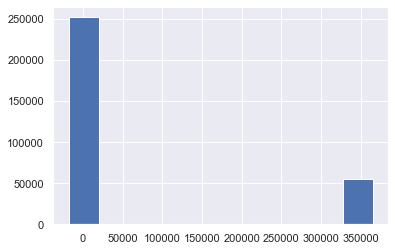

In [78]:
train_corrs_removed['DAYS_EMPLOYED'].hist().plot()

[]

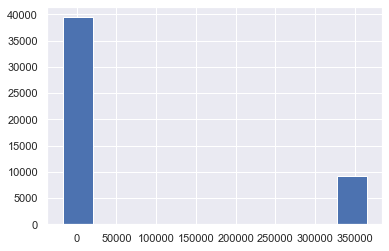

In [79]:
test_corrs_removed['DAYS_EMPLOYED'].hist().plot()

Supprimons les instances ayant ces valeurs aberrantes dans les jeux d'entrainement et test :

In [81]:
train_corrs_removed = train_corrs_removed.loc[train_corrs_removed['DAYS_EMPLOYED']<=0]
test_corrs_removed = test_corrs_removed.loc[test_corrs_removed['DAYS_EMPLOYED']<=0]

In [82]:
print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (252137, 482)
Testing Corrs Removed Shape:  (39470, 481)


In [83]:
# Pick a random 50000 instances sample (to be able to run models) 
train_sample = train_corrs_removed.sample(n=50000, axis=0)

In [84]:
# Save files
train_sample.to_csv(save_path+'train_all_merged_mean_corrs_removed_clean_50000.csv', index = False)
test_corrs_removed.to_csv(save_path+'test_all_merged_mean_corrs_removed_clean.csv', index = False)

# Modélisation

## Fonctions

### run_LGBM

In [12]:
def run_LGBM(features, test_features, encoding='ohe', n_folds=5):
    """
    Train and test a light gradient boosting model using cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use for training a model. 
            Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' 
            for one-hot encoding or 'le' for integer label encoding
        n_folds (int, default = 5): 
            number of folds to use for cross validation
        
    Return
    --------
        predictions (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model for test data.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    t0 = time()
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    print('Before encoding :\n')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    
    print('After encoding :\n')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    valid_pred = []
    valid_proba = []
    test_pred = []
    test_proba = []
    
    global probas
    probas = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        y_pred = model.predict(valid_features, num_iteration = best_iteration)
        valid_pred.append(y_pred)
        valid_proba.append(model.predict_proba(valid_features)[:, 1])
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        probas.append(model.predict_proba(test_features, num_iteration = best_iteration))
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
    
        
    # Make the submission dataframe
    predictions = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
#     valid_auc = roc_auc_score(labels, out_of_fold)  # ERROR ?
    
    # Add the overall scores to the metrics
#     valid_scores.append(valid_auc)  # cf previous error (?)
    valid_scores.append(np.mean(valid_scores))
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('mean')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    duration = time() - t0
    print('\nDone in %imin %.3fs' % (duration/60, duration%60))
    return predictions, feature_importances, metrics

### run_XGBOOST

In [13]:
def run_XGBOOST(features, test_features, encoding='ohe', n_folds=5):
    """
    Train and test a xgboost model using cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use for training a model. 
            Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' 
            for one-hot encoding or 'le' for integer label encoding
        n_folds (int, default = 5): 
            number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    t0 = time()
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    print('Before encoding :\n')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    
    print('After encoding :\n')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Convert test data into DMatrix
    dtest = xgb.DMatrix(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    global probas
    probas = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Convert data into DMatrix
        dtrain = xgb.DMatrix(train_features, label=train_labels)
        dvalid = xgb.DMatrix(valid_features, label=valid_labels)
        
        # Parameters
        params = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric':'auc'}
        
        # Train and valid data
        evals = [(dvalid, 'eval'), (dtrain, 'train')]
        
        # Create the model
        num_round = 10
        bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=100)
#         bst.save_model('0001.model')
        
        # Record the best iteration
        best_iteration = bst.best_iteration
        
        # Record the feature importances
#         feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
#         test_predictions += bst.predict(dtest, ntree_limit=bst.best_ntree_limit)[:, 1] / k_fold.n_splits
        test_predictions += bst.predict(dtest, ntree_limit=bst.best_ntree_limit) / k_fold.n_splits
        probas.append(bst.predict(dtest, ntree_limit=bst.best_ntree_limit))
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit) #[:, 1]
        
        # Record the best score
        valid_score = bst.best_score #['valid'] #['auc']
#         train_score = bst.best_score #['train'] #['auc']
        
        valid_scores.append(valid_score)
#         train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        #del model 
        del train_features, valid_features
        gc.collect()
    
    xgb.plot_importance(bst)
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
#     feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
#     train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            #'train': train_scores,
                            'valid': valid_scores}) 
    
    duration = time() - t0
    print('\nDone in %imin %.3fs' % (duration/60, duration%60))
    return submission, metrics

### plot_feature_importances

In [14]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize =(10,6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
#     ax.barh(list(reversed(list(df.index[:15]))), 
#             df['importance_normalized'].head(15), 
#             align = 'center', edgecolor = 'k')
    
    #Variables
    counts = np.array(df['importance_normalized'].head(15))
    names = np.array(df['feature'].head(15))

    #Plot
    sns.barplot(counts, names, palette='summer')

    # Set the yticks and labels
    # ax.set_yticks(list(reversed(list(df.index[:15]))))
    # ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances', fontsize=16, pad=15, **csfont)
    plt.show()
    
#     return df

### benchmark_classifiers

In [80]:
def benchmark_classifiers(features, test_features, encoding='ohe', resample=None, NaN_thresh=90):
    """
    Train and test a light gradient boosting model using cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use for training a model. 
            Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' 
            for one-hot encoding or 'le' for integer label encoding
        resample (str, default = None): 
            model to resample the umbalanced data. 
            Models available : 'SMOTE': oversampling method
                               'RUS': random undersampling
                               'CC': clusters centroids undersampling
        NaN_thresh (float or int, default=90)
            threshold (%) of NaNs to remove the column
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    t0 = time()
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    y = features['TARGET']
    
    # Weights of positive targets assigned if data are not resampled
    if resample is not None:
        pos_weight = None
        class_weights = None
    else:
        pos_weight = np.round(features['TARGET'].value_counts()[0]/features['TARGET'].value_counts()[1])
        class_weights = [1, pos_weight]
    print('Positive weight :', pos_weight)
    print()
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    # Shapes of data
    print('Before cleaning NaNs :')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # Remove columns with any NaN
#     features.dropna(how='any', axis=1, inplace=True)
#     test_features.dropna(how='any', axis=1, inplace=True)
    
    # Remove columns whose % of NaNs is greater than a threshold (NaN_thresh)
    features, test_features = remove_missing_columns(features, test_features, threshold = NaN_thresh)
    
    # Impute NaNs by mean of column
#     features.fillna(features.mean(), inplace=True)
#     test_features.fillna(test_features.mean(), inplace=True)
    
    # Impute NaNs by median of column
    features.fillna(features.median(), inplace=True)
    test_features.fillna(test_features.median(), inplace=True)

    # Shapes of data
    print('After cleaning NaNs :')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join='inner', axis=1)
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    # Shapes of data
    print('After encoding :')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # Extract feature names
    global feature_names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Benchmark of classifiers
    global clf_names
    clf_names = [#"KNN", "Linear SVM", "RBF SVM", 
#                  "Gaussian Process",
#                  "Decision Tree", 
#                  "Random Forest",
#                  "Neural Net", "AdaBoost", 
#                  "Naive Bayes", "QDA",
                 "XGBoost",
                 "LGBM",
                 "CatBoost"
            ]

    classifiers = [
#         GridSearchCV(KNeighborsClassifier(), param_grid=[{'n_neighbors':range(3,10)}]),
#         GridSearchCV(SVC(kernel="linear", probability=True), param_grid=[{'C':[0.025,0.05,0.1]}]),
#         GridSearchCV(SVC(probability=True), param_grid=[{'gamma':[1,2,3],'C':[0.1,1,2]}]),
#         GaussianProcessClassifier(1.0 * RBF(1.0)),
#         DecisionTreeClassifier(max_depth=2, min_samples_split=2),
# #                      param_grid=[{'max_depth':[2,5,8],'min_samples_split':[1,2]}]),
#         RandomForestClassifier(max_depth=2, max_features=1, n_estimators=10),
# #                      param_grid=[{'max_depth':[2,5,8],'n_estimators':[10,50,100],'max_features':[1,2]}]),
#         MLPClassifier(alpha=2, max_iter=1000),
# #                      param_grid=[{'alpha':[2,3,5],'max_iter':[1000,2000,3000]}]),
#         AdaBoostClassifier(), 
# #                      param_grid=[{'n_estimators':[10,50,100], 'learning_rate':[0.1,1]}])
#         GaussianNB(),
#         QuadraticDiscriminantAnalysis(), 
        XGBClassifier(max_depth=4, eta=0.01, n_estimators=100, 
                      objective='binary:logistic', 
                      scale_pos_weight=pos_weight), 
#                        param_grid=[{'max_depth':[4,8], 'eta':[0.01,0.1,1], 'objective':['binary:logistic'],
#                                  'n_estimators':[100, 1000],'scale_pos_weight':[pos_weight]}]),
        lgb.LGBMClassifier(n_estimators=10000, 
                           objective = 'binary', # 'binary', logloss_obj
                           class_weight = 'balanced', 
                           scale_pos_weight = pos_weight,
                           learning_rate = 0.05, 
                           reg_alpha = 0.1, reg_lambda = 0.1, 
                           #max_depth = 5,
                           subsample = 0.8, n_jobs = -1, random_state = 50),
        CatBoostClassifier(iterations=10,
                           depth=3,
                           learning_rate=0.1,
                           loss_function='Logloss',
#                            objective = logloss_obj,
#                            eval_metric = logloss_eval,
                           class_weights=class_weights,
                           verbose=True)
    ]
    
    # Separating data into train and valid sets
    global X_train, X_valid, y_train, y_valid
    global test_norm
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(features)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=.7, random_state=42)
    
    # return encoded and normalized test data
    test_norm = scaler.fit_transform(test_features)
    
    # Rebalance imbalanced class through oversampling
    print('Resampling model :', resample)
    if resample=='SMOTE':
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    
    # Rebalance imbalanced class through undersampling
    if resample=='RUS':
        undersampling = RandomUnderSampler(random_state=42)
        X_train, y_train = undersampling.fit_resample(X_train, y_train)

    if resample=='CC':
        undersampling = ClusterCentroids(random_state=42)
        X_train, y_train = undersampling.fit_resample(X_train, y_train)

    # Shapes of data
    if resample==None:
        print('After separating data:')
    else:
        print('After separating and resampling data:')
    print('Training shape: ', X_train.shape)
    print('Validating shape: ', X_valid.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    valid_scores = []
    valid_pred = []
    valid_proba = []
    test_pred = []
    test_proba = []
    log_loss_scores = []
    roc_auc_scores = []
    
    # Dict of model (fitted on train data)
    global models
    models = {}
    
    esr = 100 # early stopping rounds
    
    # iterate over classifiers
    for name, clf in zip(clf_names, classifiers):
        if name=='XGBoost':
            model= clf.fit(X_train, y_train, eval_metric = 'logloss',
                           eval_set = [(X_valid, y_valid)],
                           early_stopping_rounds = esr, verbose = False)
        elif name=='LGBM':
            model= clf.fit(X_train, y_train, 
                           eval_metric = 'logloss', #'logloss', logloss_eval
                           eval_set = [(X_valid, y_valid)], eval_names = ['valid'], 
                           categorical_feature = 'auto', #cat_indices,
                           early_stopping_rounds = esr, verbose = 200)

        elif name=='CatBoost':
            model= clf.fit(X_train, y_train,
                           eval_set = [(X_valid, y_valid)],
                           early_stopping_rounds=esr, verbose = True)    
        else:
            model = clf.fit(X_train, y_train)
            
        models[name]= model
        y_pred = model.predict(X_valid)
        score = accuracy_score(y_valid, y_pred)
#         score = clf.score(y_pred, y_valid)
        valid_scores.append(score)
    
        valid_pred.append(y_pred)
        valid_proba.append(model.predict_proba(X_valid)[:, 1])

        # predictions on test data
        test_pred.append(model.predict(test_features))
        test_proba.append(model.predict_proba(test_features)[:, 1])
        
        # log loss function
        log_loss_scores.append(log_loss(y_valid, model.predict_proba(X_valid)[:, 1]))
        
        # ROC curve and AUC
        global fpr, tpr, thresholds
        fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
        roc_auc_scores.append(roc_auc_score(y_valid, y_pred))
        
        # display best estimator from Cross Validation
#         print('Best parameters for {} : \n {}'.format(name, clf.best_estimator_))

    # Dataframe of classifiers scores  
    scores_df = pd.DataFrame(np.round(valid_scores,3), columns=['Valid Accuracy'], index=[clf_names])
    scores_df['Log_loss'] = np.round(log_loss_scores,3)
    scores_df['AUC'] = np.round(roc_auc_scores,3)
    
    # Predictions dataframe
    predictions = pd.DataFrame({'SK_ID_CURR': test_ids, 
                                str(clf_names[0]): test_pred[0],
                                str(clf_names[0])+' (proba)': test_proba[0],
                                str(clf_names[1]): test_pred[1],
                                str(clf_names[1])+' (proba)': test_proba[1],
                                str(clf_names[2]): test_pred[2],
                                str(clf_names[2])+' (proba)': test_proba[2]
                               })

    duration = time() - t0
    print('\nDone in %imin %.1fs' % (duration/60, duration%60))
    
#     return scores_df, valid_pred, test_pred, valid_proba, test_proba
    return predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba

### custom objective / eval functions

#### test

In [16]:
def custom_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*0.1*residual, -2*residual)
    hess = np.where(residual<0, 2*0.1, 2.0)
    return grad, hess

def custom_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual<0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

#### logloss

In [17]:
# Best scores for LGBM not resampled : (first formulae)
#beta = 10
#beta_h = 2

def logloss_obj(y_true, y_pred):
    y_pred = 1. / (1. + np.exp(-y_pred)) # convert y_pred into proba
    beta = 4
    beta_h = 2.
    
    # first formulae
#     grad = beta * (y_pred - y_true)
#     hess = beta_h * y_pred * (1.0 - y_pred)
    
    # second formulae
    grad = y_pred * ((beta-1) * y_true + 1) - beta * y_true
    hess = ((beta - 1) * y_true + 1) * y_pred * (1.0 - y_pred)
    
    return grad, hess

def logloss_eval(y_true, y_pred):
#     y_pred = np.clip(y_pred, 10e-7, 1-10e-7)
    y_pred = 1. / (1. + np.exp(-y_pred))
    loss_fn = y_true*np.log(y_pred)
    loss_fp = (1.0 - y_true)*np.log(1.0 - y_pred)
    loss = np.sum(-(10*loss_fn+loss_fp))/len(y_true)
    return 'custom logloss', loss, False

#### focal loss

In [18]:
def focal_loss_lgb(y_true, y_pred, alpha, gamma):
    a,g = alpha, gamma
#     y_true = dtrain.label
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess

def focal_loss_lgb_eval_error(y_true, y_pred, alpha, gamma):
    a,g = alpha, gamma
#     y_true = dtrain.label
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) \
           * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    # (eval_name, eval_result, is_higher_better)
    return 'focal_loss', np.mean(loss), False

def focal_loss_lgb_f1_score(y_true, y_pred):
#     y_pred = predict_proba(y_pred)
    binary_pred = [int(p>0.5) for p in y_pred]
    return 'f1', f1_score(y_true, binary_pred), True

In [19]:
focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha=0.25, gamma=2.)
focal_loss_eval = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha=0.25, gamma=2.)
# model = lgb.train(best, self.lgtrain, fobj=focal_loss, feval=focal_loss_eval)

### plot_confusion_matrix

In [36]:
def plot_confusion_matrix(conf_matrix, name):
    """
    Plot the given confusion_matrix like a sns heatmap.
    Arg "name" is used in the graph title and file name.
    """
    fig = plt.figure(figsize=(10,5))

    #Heatmap
    ax = sns.heatmap(conf_matrix, square=True, cmap='Blues', lw=0.3, annot=True, fmt='d', cbar=None)

    # Fix the bottom and top half-cut problem
    b, t = plt.ylim() # top/bottom values
    b += 0.5 # add 0.5 to bottom
    t -= 0.5 # subtract 0.5 to top
    plt.ylim(b, t) # right dimensions

    # Add elements and save
    ax.set_xticklabels(target_names, fontsize=12, rotation=0, horizontalalignment='center')
    ax.set_yticklabels(target_names, fontsize=12, rotation=0)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')

    plt.title('Confusion matrix of {} predictions'.format(name), fontsize=18, pad=20, **csfont)
    plt.savefig(save_path+'ConfMatrix_{}.png'.format(name), dpi=200, bbox_inches='tight')
    plt.show()

### KMeans_loop

In [21]:
def KMeans_loop(X, range_n_clusters, KMeans_scores, save_path, proj=None):
    """
    Fonction pour faire une boucle de KMeans en faisant varier le nombre de clusters
    Trace pour chaque itération un graphe avec les scores silhouette et visualisation t-SNE du Kmeans 
    et calcule différents scores de clustering sauvegardés dans un dictionnaire
    
    Scores calculés : silhouette, Davies-Bouldin, Calinski-Harabasz
    Pour le score silhouette, on calcule la moyenne pour tous les clusters et celle de chaque cluster
    pour tracer le graphe de gauche

    Une boucle est réalisée à chaque itération pour vérifier la stabilité des scores (calcul de la std)
    Nombre d'itérations par défaut : 10
    
    Une projection des données en 2 dimensions est effectuée selon le choix de l'utilisateur pour visualiser 
    le clustering.
    
    Args :
        - X : variables d'entrée sur lesquelles effectuer le clustering
        - range_n_clusters : liste du nombre de clusters à tester
        - KMeans_scores : dictionnaire pour sauvegarder les scores
        - save_path : sauvegarde les graphes dans ce dossier
        - proj : type de projection des données en 2D (UMAP, t-SNE, PCA) - Aucune par défaut.
    """
    
    t0 = time()
    
    # projections choosen by user to visualize clustering
    if proj=='UMAP':
        reducer = umap.UMAP(random_state=42)
        X_umap = reducer.fit_transform(X)
        X_proj = X_umap
    elif proj=='TSNE':
        tsne = manifold.TSNE(n_components=2, perplexity=40, n_iter=3000, init='pca')
        X_tsne = tsne.fit_transform(X)
        X_proj = X_tsne
    elif proj=='PCA':
        pca = decomposition.PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        X_proj = X_pca
    else:
        X_proj = X

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1
        # but we fix the limit here
        ax1.set_xlim([-0.1, 1])

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Save scores
        inertia = []
        silhouettes = [] 
        davies_bouldin = []
        calinski_harabasz = []
        
        # Pour tester la stabilité du KMeans
#         for j in range(10):
        cls = KMeans(n_clusters=n_clusters)
        cluster_labels = cls.fit_predict(X)

        inertia.append(cls.inertia_)
        silhouettes.append(silhouette_score(X, cluster_labels))
        davies_bouldin.append(davies_bouldin_score(X, cluster_labels))
        calinski_harabasz.append(calinski_harabasz_score(X, cluster_labels))
        

    #     print("For n_clusters = %i \n" % n_clusters)
    #     print("Average silhouette score : %0.3f (+/- %0.3f)" % (np.mean(silhouettes), np.std(silhouettes)))
    #     print("Davies-Bouldin : %0.3f" % (np.mean(davies_bouldin), np.std(davies_bouldin)))
    #     print("Calinski-Harabasz : %0.3f" % (np.mean(calinski_harabasz), np.std(calinski_harabasz)))

#         KMeans_scores.append([np.mean(silhouettes), np.std(silhouettes),
#                               np.mean(davies_bouldin), np.std(davies_bouldin),
#                               np.mean(calinski_harabasz), np.std(calinski_harabasz)])
        
        KMeans_scores.append([np.mean(silhouettes),
                              np.mean(davies_bouldin),
                              np.mean(calinski_harabasz),
                              np.mean(inertia)])
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.tab10(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_score(X, cluster_labels), color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.tab10(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X_proj[:, 0], X_proj[:, 1], marker='.', s=200, lw=0.5, alpha=0.8,
                    c=colors, edgecolor='k')

#         # Labeling the clusters
#         centers = cls.cluster_centers_
#         #centers_tsne = tsne.fit_transform(centers)
#         #centers_umap = reducer.fit_transform(centers)

#         # Draw white circles at cluster centers
#         ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                     c="white", alpha=1, s=200, edgecolor='k')

#         for i, c in enumerate(centers):
#             ax2.scatter(c[0], c[1], marker='$%d$' % i, 
#                         alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering with n_clusters = %d" % n_clusters),
                     fontsize=16, **csfont)
        
        plt.savefig(save_path+'/KMeans_K{}_clusters.png'.format(n_clusters), dpi=200, bbox_inches='tight')

    plt.show()
    
    duration = time() - t0
    print('\nDone in %imin %.3fs' % (duration/60, duration%60))

## Tests de modèles

In [3]:
save_path = 'Figures/'

In [4]:
train = pd.read_csv('Fichiers/train_bureau_corrs_removed.csv')
test = pd.read_csv('Fichiers/test_bureau_corrs_removed.csv')

### Light GBM

In [22]:
predictions, feature_importances, metrics = run_LGBM(train,test)

Before encoding :

Training shape:  (307511, 200)
Testing shape:  (48744, 200)

After encoding :

Training shape:  (307511, 321)
Testing shape:  (48744, 321)

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806016	train's binary_logloss: 0.541242	valid's auc: 0.763131	valid's binary_logloss: 0.556363
[400]	train's auc: 0.837991	train's binary_logloss: 0.508956	valid's auc: 0.763133	valid's binary_logloss: 0.536274
Early stopping, best iteration is:
[307]	train's auc: 0.824471	train's binary_logloss: 0.52273	valid's auc: 0.763942	valid's binary_logloss: 0.544814
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806019	train's binary_logloss: 0.541253	valid's auc: 0.764572	valid's binary_logloss: 0.560461
Early stopping, best iteration is:
[263]	train's auc: 0.817418	train's binary_logloss: 0.529915	valid's auc: 0.764946	valid's binary_logloss: 0.553335
Training until validation scores don't improve for 100 rounds
[200]	

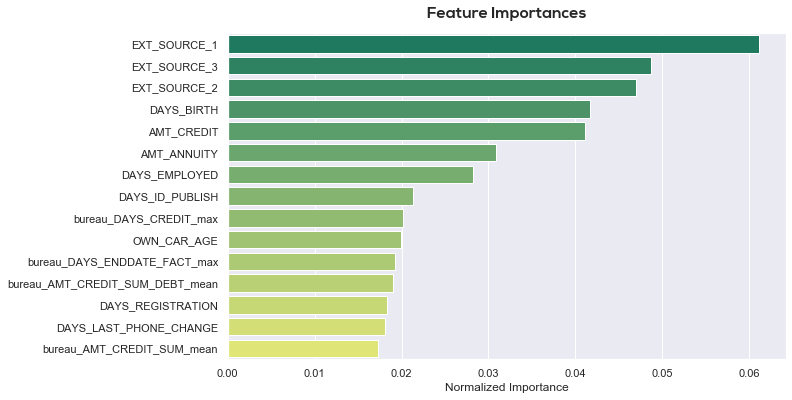

In [23]:
plot_feature_importances(feature_importances)

In [24]:
metrics

fold     train     valid
0     0  0.824471  0.763942
1     1  0.817418  0.764946
2     2  0.835671  0.757278
3     3  0.815857  0.763879
4     4  0.805918  0.764587
5  mean  0.819867  0.762926

In [25]:
train_sample = train.iloc[:1000,:]
test_sample = test.iloc[:1000,:]

In [26]:
pred_sample, fi_sample, metrics_sample = run_LGBM(train_sample,test_sample)

Before encoding :

Training shape:  (1000, 200)
Testing shape:  (1000, 200)

After encoding :

Training shape:  (1000, 303)
Testing shape:  (1000, 303)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	train's auc: 1	train's binary_logloss: 0.206862	valid's auc: 0.798759	valid's binary_logloss: 0.320155
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	train's auc: 0.998824	train's binary_logloss: 0.314618	valid's auc: 0.760369	valid's binary_logloss: 0.406905
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 1	train's binary_logloss: 0.00638762	valid's auc: 0.824505	valid's binary_logloss: 0.244102
Early stopping, best iteration is:
[119]	train's auc: 1	train's binary_logloss: 0.0240445	valid's auc: 0.824144	valid's binary_logloss: 0.226318
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	train's au

In [27]:
metrics_sample

fold     train     valid
0     0  1.000000  0.798759
1     1  0.998824  0.760369
2     2  1.000000  0.824144
3     3  1.000000  0.584944
4     4  1.000000  0.763587
5  mean  0.999765  0.746361

In [28]:
np.shape(probas)

(5, 1000, 2)

In [29]:
probas

[array([[0.87279713, 0.12720287],
        [0.67728266, 0.32271734],
        [0.80063314, 0.19936686],
        ...,
        [0.20910716, 0.79089284],
        [0.1523608 , 0.8476392 ],
        [0.85796551, 0.14203449]]),
 array([[0.80962311, 0.19037689],
        [0.68237714, 0.31762286],
        [0.7948167 , 0.2051833 ],
        ...,
        [0.24761647, 0.75238353],
        [0.20676623, 0.79323377],
        [0.79566592, 0.20433408]]),
 array([[0.99512898, 0.00487102],
        [0.9614135 , 0.0385865 ],
        [0.99637787, 0.00362213],
        ...,
        [0.61289225, 0.38710775],
        [0.36581585, 0.63418415],
        [0.94606126, 0.05393874]]),
 array([[0.97489947, 0.02510053],
        [0.96890454, 0.03109546],
        [0.98405935, 0.01594065],
        ...,
        [0.44263597, 0.55736403],
        [0.09174678, 0.90825322],
        [0.88430771, 0.11569229]]),
 array([[0.81066286, 0.18933714],
        [0.76953288, 0.23046712],
        [0.94638367, 0.05361633],
        ...,
        [

In [30]:
pred_sample

SK_ID_CURR    TARGET
0        100001  0.107378
1        100005  0.188098
2        100013  0.095546
3        100028  0.175770
4        100038  0.331741
..          ...       ...
995      106851  0.083689
996      106852  0.098678
997      106853  0.675182
998      106854  0.784317
999      106861  0.127339

[1000 rows x 2 columns]

In [31]:
train_sample = train.iloc[:10000,:]
test_sample = test.iloc[:1000,:]

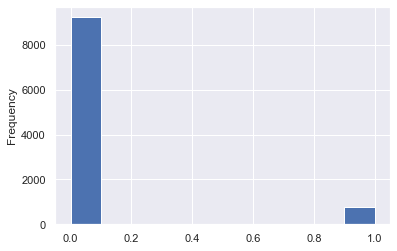

In [32]:
train_sample['TARGET'].astype(int).plot.hist();

In [33]:
pred_sample, fi_sample, metrics_sample = run_LGBM(train_sample,test_sample)

Before encoding :

Training shape:  (10000, 200)
Testing shape:  (1000, 200)

After encoding :

Training shape:  (10000, 304)
Testing shape:  (1000, 304)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.921682	train's binary_logloss: 0.486151	valid's auc: 0.76646	valid's binary_logloss: 0.524728
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	train's auc: 0.961925	train's binary_logloss: 0.372278	valid's auc: 0.711158	valid's binary_logloss: 0.460924
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.948165	train's binary_logloss: 0.411	valid's auc: 0.749261	valid's binary_logloss: 0.468745
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	train's auc: 0.977851	train's binary_logloss: 0.321135	valid's auc: 0.739078	valid's binary_logloss: 0.414831
T

In [34]:
pred_sample

SK_ID_CURR    TARGET
0        100001  0.225650
1        100005  0.398163
2        100013  0.167372
3        100028  0.272691
4        100038  0.641004
..          ...       ...
995      106851  0.345513
996      106852  0.205216
997      106853  0.584812
998      106854  0.801483
999      106861  0.172377

[1000 rows x 2 columns]

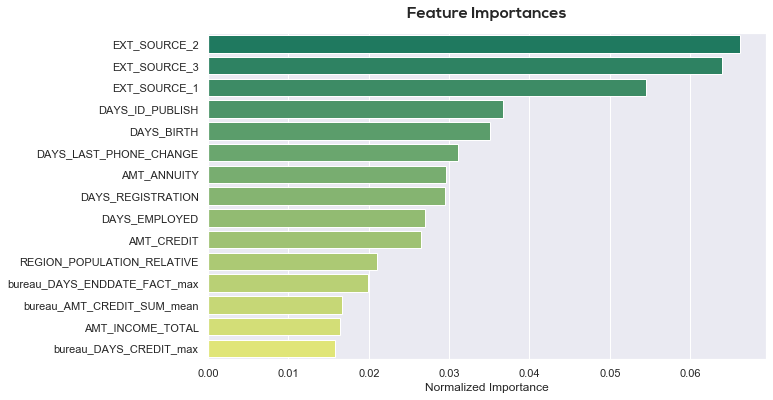

In [35]:
plot_feature_importances(fi_sample)

In [36]:
metrics_sample

fold     train     valid
0     0  0.921682  0.766460
1     1  0.961925  0.711158
2     2  0.948165  0.749261
3     3  0.977851  0.739078
4     4  0.975318  0.740170
5  mean  0.956988  0.741225

In [37]:
train_sample = train.iloc[:10000,:]
test_sample = test.iloc[:1000,:]

In [49]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, resample='SMOTE')

Positive weight : None

Before cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

There are 0 columns with greater than 90% missing values.
After cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

After encoding :
Training shape:  (10000, 271)
Testing shape:  (100, 271)

Resampling model : SMOTE
After separating and resampling data:
Training shape:  (12950, 271)
Validating shape:  (3000, 271)
Testing shape:  (100, 271)

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.999785	train's binary_logloss: 0.0564461	valid's auc: 0.738785	valid's binary_logloss: 0.26134
Early stopping, best iteration is:
[122]	train's auc: 0.997728	train's binary_logloss: 0.0925235	valid's auc: 0.750617	valid's binary_logloss: 0.255617

Done in 0min 11.6s


In [50]:
scores_df

Valid Accuracy  Log_loss    AUC
LGBM           0.917     0.256  0.515

In [51]:
valid_pred

[array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]

In [52]:
valid_proba

[array([0.06750305, 0.01384607, 0.03825065, ..., 0.04394364, 0.01665417,
        0.22972535])]

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2750
           1       0.53      0.03      0.06       250

    accuracy                           0.92      3000
   macro avg       0.73      0.51      0.51      3000
weighted avg       0.89      0.92      0.88      3000



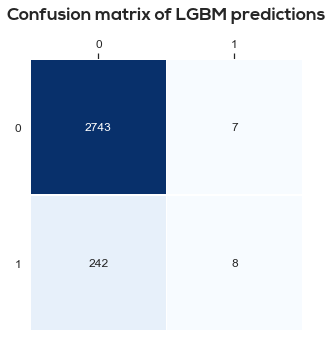

In [53]:
target_names = ['0','1']

model_ID = 0

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

### XGBOOST 

In [43]:
train_sample = train.iloc[:10000,:]
test_sample = test.iloc[:100,:]

Before encoding :

Training shape:  (10000, 200)
Testing shape:  (100, 200)

After encoding :

Training shape:  (10000, 271)
Testing shape:  (100, 271)

[0]	eval-auc:0.66728	train-auc:0.64434
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 100 rounds.
[1]	eval-auc:0.72548	train-auc:0.69823
[2]	eval-auc:0.73160	train-auc:0.72848
[3]	eval-auc:0.75284	train-auc:0.74441
[4]	eval-auc:0.75498	train-auc:0.75980
[5]	eval-auc:0.76099	train-auc:0.77121
[6]	eval-auc:0.76550	train-auc:0.78109
[7]	eval-auc:0.76148	train-auc:0.79028
[8]	eval-auc:0.76537	train-auc:0.79537
[9]	eval-auc:0.76763	train-auc:0.79970
[0]	eval-auc:0.65062	train-auc:0.67935
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 100 rounds.
[1]	eval-auc:0.67636	train-auc:0.72090
[2]	eval-auc:0.68179	train-auc:0.72796
[3]	eval-auc:0.69388	train-auc:0.75468
[4]	eval-auc:

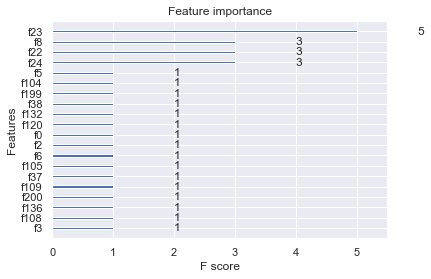

In [44]:
submission, metrics = run_XGBOOST(train_sample, test_sample)

In [45]:
submission

SK_ID_CURR    TARGET
0       100001  0.022779
1       100005  0.065552
2       100013  0.018243
3       100028  0.035585
4       100038  0.248899
..         ...       ...
95      100752  0.030487
96      100753  0.368599
97      100754  0.217458
98      100760  0.020734
99      100762  0.039078

[100 rows x 2 columns]

In [46]:
metrics

fold     valid
0        0  0.799703
1        1  0.806199
2        2  0.801049
3        3  0.798099
4        4  0.805021
5  overall  0.732214

In [55]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, resample='SMOTE')

Positive weight : None

Before cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

There are 0 columns with greater than 90% missing values.
After cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

After encoding :
Training shape:  (10000, 271)
Testing shape:  (100, 271)

Resampling model : SMOTE
After separating and resampling data:
Training shape:  (12950, 271)
Validating shape:  (3000, 271)
Testing shape:  (100, 271)


Done in 0min 12.7s


In [56]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost           0.823     0.504  0.598

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      2750
           1       0.18      0.33      0.24       250

    accuracy                           0.82      3000
   macro avg       0.56      0.60      0.57      3000
weighted avg       0.87      0.82      0.84      3000



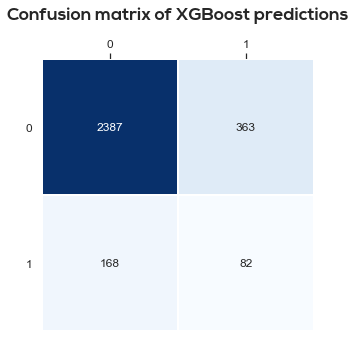

In [57]:
target_names = ['0','1']

model_ID = 0

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [58]:
valid_proba[:50]

[array([0.3763171 , 0.23235081, 0.31744853, ..., 0.2965395 , 0.26280528,
        0.40024027], dtype=float32)]

In [59]:
valid_pred[:100]

[array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]

### Benchmark de classifiers

#### Tests différents classifiers

In [44]:
train_sample = train.iloc[:1000,:]
test_sample = test.iloc[:100,:]
target_names = ['0','1']

In [45]:
scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample)#, resample='SMOTE')

Positive weight : 13.0

Before cleaning NaNs :
Training shape:  (1000, 200)
Testing shape:  (100, 200)

There are 0 columns with greater than 90% missing values.
After cleaning NaNs :
Training shape:  (1000, 200)
Testing shape:  (100, 200)

After encoding :
Training shape:  (1000, 271)
Testing shape:  (100, 271)

Resampling model : None
After separating data:
Training shape:  (700, 271)
Validating shape:  (300, 271)
Testing shape:  (100, 271)


Done in 0min 41.0s


In [46]:
scores_df

Valid Accuracy  Log_loss    AUC
KNN                        0.930     1.399  0.500
Linear SVM                 0.910     0.244  0.533
RBF SVM                    0.930     0.254  0.500
Gaussian Process           0.883     0.693  0.541
Decision Tree              0.930     0.227  0.500
Random Forest              0.930     0.254  0.500
Neural Net                 0.910     0.300  0.511
AdaBoost                   0.920     0.578  0.605
Naive Bayes                0.317    23.602  0.567
QDA                        0.903     3.339  0.508

In [47]:
np.shape(test_pred),np.shape(test_proba)

((10, 100), (10, 100))

In [33]:
# LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, feature_names=feature_names, class_names=[0,1], discretize_continuous=True)

In [57]:
model = 'Random Forest'
client_ID = 0

exp = explainer.explain_instance(X_valid[client_ID], models[model].predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

In [32]:
scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, resample='SMOTE')

Positive weight : None

Before cleaning NaNs :
Training shape:  (1000, 200)
Testing shape:  (100, 200)

There are 0 columns with greater than 90% missing values.
After cleaning NaNs :
Training shape:  (1000, 200)
Testing shape:  (100, 200)

After encoding :
Training shape:  (1000, 271)
Testing shape:  (100, 271)

Resampling model : SMOTE
After separating and resampling data:
Training shape:  (1302, 271)
Validating shape:  (300, 271)
Testing shape:  (100, 271)


Done in 2min 30.5s


In [35]:
scores_df

Valid Accuracy  Log_loss    AUC
KNN                        0.557     7.863  0.541
Linear SVM                 0.823     0.534  0.531
RBF SVM                    0.930     0.342  0.500
Gaussian Process           0.853     0.426  0.547
Decision Tree              0.710     0.488  0.448
Random Forest              0.630     0.657  0.537
Neural Net                 0.867     0.413  0.532
AdaBoost                   0.860     0.606  0.528
Naive Bayes                0.317    23.482  0.545
QDA                        0.920     2.763  0.517

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       279
           1       0.00      0.00      0.00        21

    accuracy                           0.93       300
   macro avg       0.47      0.50      0.48       300
weighted avg       0.86      0.93      0.90       300



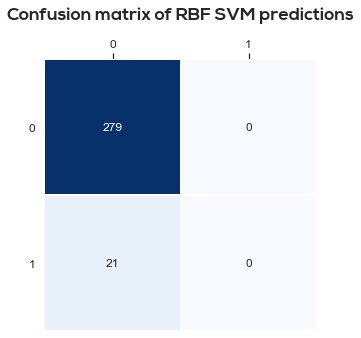

In [53]:
model = 'RBF SVM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [55]:
p = 50

print("Model :", scores_df.index[model_ID][0])
print('Score:', scores_df['Valid Accuracy'][model_ID])
print()
print(y_valid.values[:p])
print()
print(valid_pred[model_ID][:p])
print(valid_proba[model_ID][:p])
print()
print(test_pred[model_ID][:p])
print(test_proba[model_ID][:p])

Model : RBF SVM
Score: 0.93

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625

#### Tests LBGM / XGBoost / CatBoost

##### bureau / bureau_balance

In [61]:
train_sample = train.iloc[:10000,:]
test_sample = test.iloc[:100,:]
target_names = ['0','1']

The selected dataframe has 202 columns.
There are 148 columns that have missing values.


[]

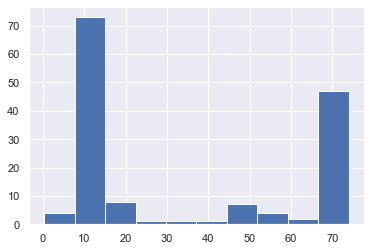

In [62]:
df = missing_values_table(train_sample)
df['% of Total Values'].hist().plot()

In [63]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, NaN_thresh=30) #, resample='RUS')

Positive weight : 12.0

Before cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

There are 62 columns with greater than 30% missing values.
After cleaning NaNs :
Training shape:  (10000, 138)
Testing shape:  (100, 138)

After encoding :
Training shape:  (10000, 191)
Testing shape:  (100, 191)

Resampling model : None
After separating data:
Training shape:  (7000, 191)
Validating shape:  (3000, 191)
Testing shape:  (100, 191)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.742622	train's binary_logloss: 0.679426	valid's auc: 0.679959	valid's binary_logloss: 0.70706

Done in 0min 6.3s


In [64]:
predictions

SK_ID_CURR  XGBoost  XGBoost (proba)  LGBM  LGBM (proba)
0       100001        0         0.362269     0      0.475185
1       100005        0         0.294552     0      0.475185
2       100013        0         0.302795     0      0.475185
3       100028        0         0.317017     0      0.475185
4       100038        0         0.290062     0      0.475185
..         ...      ...              ...   ...           ...
95      100752        0         0.317738     0      0.475185
96      100753        0         0.406003     0      0.475185
97      100754        0         0.400720     0      0.475185
98      100760        0         0.290062     0      0.475185
99      100762        0         0.283303     0      0.475185

[100 rows x 5 columns]

In [65]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost           0.712     0.593  0.655
LGBM              0.333     0.707  0.580

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      2750
           1       0.16      0.59      0.25       250

    accuracy                           0.71      3000
   macro avg       0.56      0.66      0.54      3000
weighted avg       0.88      0.71      0.77      3000



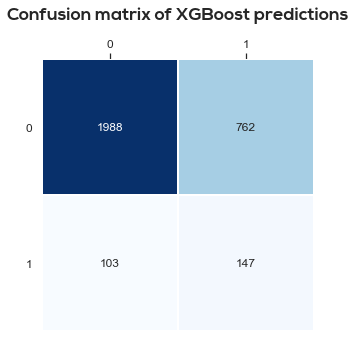

In [66]:
model_ID = 0

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.28      0.44      2750
           1       0.10      0.88      0.18       250

    accuracy                           0.33      3000
   macro avg       0.53      0.58      0.31      3000
weighted avg       0.89      0.33      0.42      3000



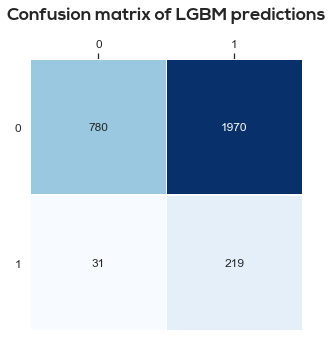

In [67]:
model_ID = 1

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [81]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, resample='RUS', NaN_thresh=30)

Positive weight : None

Before cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

There are 62 columns with greater than 30% missing values.
After cleaning NaNs :
Training shape:  (10000, 138)
Testing shape:  (100, 138)

After encoding :
Training shape:  (10000, 191)
Testing shape:  (100, 191)

Resampling model : RUS
After separating and resampling data:
Training shape:  (1050, 191)
Validating shape:  (3000, 191)
Testing shape:  (100, 191)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.965979	train's binary_logloss: 0.42009	valid's auc: 0.72194	valid's binary_logloss: 0.633929

Done in 0min 2.7s


In [82]:
predictions

SK_ID_CURR  XGBoost  XGBoost (proba)  LGBM  LGBM (proba)
0       100001        0         0.329598     0      0.279345
1       100005        0         0.358517     0      0.256219
2       100013        0         0.345674     0      0.256455
3       100028        0         0.360472     0      0.255492
4       100038        0         0.345713     0      0.244585
..         ...      ...              ...   ...           ...
95      100752        0         0.364064     0      0.231885
96      100753        0         0.373488     0      0.302378
97      100754        0         0.348176     0      0.343978
98      100760        0         0.360472     0      0.231885
99      100762        0         0.327772     0      0.250603

[100 rows x 5 columns]

In [83]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost           0.676     0.632  0.667
LGBM              0.656     0.634  0.663

              precision    recall  f1-score   support

           0       0.96      0.68      0.79      2750
           1       0.16      0.66      0.25       250

    accuracy                           0.68      3000
   macro avg       0.56      0.67      0.52      3000
weighted avg       0.89      0.68      0.75      3000



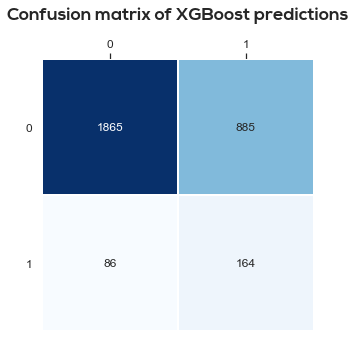

In [84]:
model_ID = 0

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [85]:
i = 1
a = -( y_valid.values[i] * np.log10(valid_proba[model_ID][i]) + \
                 (1 - y_valid.values[i]) * np.log10(1 - valid_proba[model_ID][i]) )
a

0.22690434448103244

In [86]:
from sklearn import metrics
precision = metrics.precision_score(y_valid, valid_pred[model_ID])
recall = metrics.recall_score(y_valid, valid_pred[model_ID])
f1 = metrics.f1_score(y_valid, valid_pred[model_ID])
f2 = 5 * (precision * recall) / (4 * precision + recall)

logloss = []
for i in range(len(y_valid)):
    logloss.append( -( y_valid.values[i] * np.log10(valid_proba[model_ID][i]) + \
                 (1 - y_valid.values[i]) * np.log10(1 - valid_proba[model_ID][i]) ))
    
print('Precision :', precision)
print('Recall :', recall)
print('F1 score :', f1)
print('F2 score :', f2)
print('Log loss :', np.mean(logloss))

Precision : 0.1563393708293613
Recall : 0.656
F1 score : 0.2525019245573518
F2 score : 0.4001952171791118
Log loss : 0.27445452934930925


              precision    recall  f1-score   support

           0       0.96      0.65      0.78      2750
           1       0.15      0.67      0.25       250

    accuracy                           0.66      3000
   macro avg       0.55      0.66      0.51      3000
weighted avg       0.89      0.66      0.73      3000



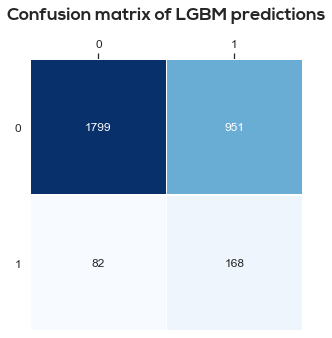

In [74]:
model_ID = 1

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [75]:
from sklearn import metrics
precision = metrics.precision_score(y_valid, valid_pred[model_ID])
recall = metrics.recall_score(y_valid, valid_pred[model_ID])
f1 = metrics.f1_score(y_valid, valid_pred[model_ID])
f2 = 5 * (precision * recall) / (4 * precision + recall)
print('Precision :', precision)
print('Recall', recall)
print('F1 score', f1)
print('F2 score', f2)

Precision : 0.15013404825737264
Recall 0.672
F1 score 0.24543462381300218
F2 score 0.3964134025483718


In [76]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, resample='SMOTE', NaN_thresh=30)

Positive weight : None

Before cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

There are 62 columns with greater than 30% missing values.
After cleaning NaNs :
Training shape:  (10000, 138)
Testing shape:  (100, 138)

After encoding :
Training shape:  (10000, 191)
Testing shape:  (100, 191)

Resampling model : SMOTE
After separating and resampling data:
Training shape:  (12950, 191)
Validating shape:  (3000, 191)
Testing shape:  (100, 191)

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.999699	train's binary_logloss: 0.0607997	valid's auc: 0.712623	valid's binary_logloss: 0.266965
Early stopping, best iteration is:
[112]	train's auc: 0.996543	train's binary_logloss: 0.104252	valid's auc: 0.736013	valid's binary_logloss: 0.259716

Done in 0min 14.7s


In [77]:
predictions

SK_ID_CURR  XGBoost  XGBoost (proba)  LGBM  LGBM (proba)
0       100001        1         0.699827     1      0.947334
1       100005        1         0.715202     1      0.931713
2       100013        1         0.755136     1      0.904418
3       100028        1         0.689664     1      0.771868
4       100038        1         0.700576     1      0.864095
..         ...      ...              ...   ...           ...
95      100752        1         0.747078     1      0.930594
96      100753        1         0.698046     1      0.953599
97      100754        1         0.697620     1      0.952096
98      100760        1         0.746330     1      0.901701
99      100762        1         0.690796     1      0.950809

[100 rows x 5 columns]

In [78]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost           0.802     0.515  0.605
LGBM              0.917     0.260  0.516

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      2750
           1       0.17      0.37      0.24       250

    accuracy                           0.80      3000
   macro avg       0.56      0.60      0.56      3000
weighted avg       0.87      0.80      0.83      3000



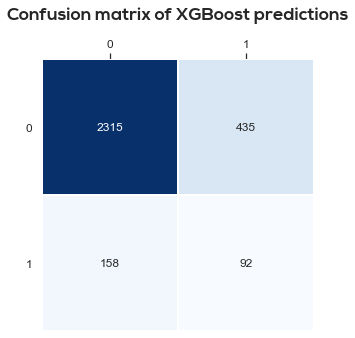

In [79]:
model_ID = 0

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2750
           1       0.50      0.04      0.07       250

    accuracy                           0.92      3000
   macro avg       0.71      0.52      0.51      3000
weighted avg       0.88      0.92      0.88      3000



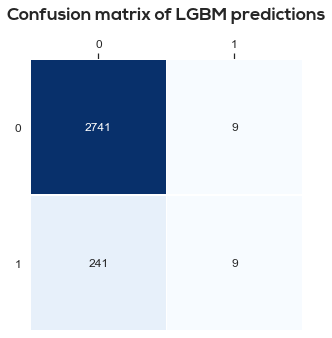

In [80]:
model_ID = 1

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

##### Avec toutes les variables réunies

In [3]:
# Random 50000 rows
# train = pd.read_csv('Fichiers/train_all_merged_mean_corrs_removed_random_50000.csv')
# test = pd.read_csv('Fichiers/test_all_merged_mean_corrs_removed.csv')

In [3]:
# Random 50000 rows
train = pd.read_csv('Fichiers/Clean/train_all_merged_mean_corrs_removed_clean_50000.csv')
test = pd.read_csv('Fichiers/Clean/test_all_merged_mean_corrs_removed_clean.csv')

In [4]:
print('Training Shape: ', train.shape)
print('Testing Shape: ', test.shape)

Training Shape:  (50000, 482)
Testing Shape:  (39470, 481)


In [5]:
train_sample = train.iloc[:50000,:]
test_sample = test.iloc[:100,:]
target_names = ['0','1']

In [6]:
# Convert TARGET boolean into integers (cf. how data was built) 
train_sample['TARGET'] = train_sample['TARGET'].astype(int)
train_sample['TARGET'].unique()

array([0, 1])

In [36]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, NaN_thresh=20) #, resample='RUS')

Positive weight : 11.0

Before cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (100, 480)

There are 3 columns with greater than 20% missing values.
After cleaning NaNs :
Training shape:  (50000, 477)
Testing shape:  (100, 477)

After encoding :
Training shape:  (50000, 530)
Testing shape:  (100, 530)

Resampling model : None
After separating data:
Training shape:  (35000, 530)
Validating shape:  (15000, 530)
Testing shape:  (100, 530)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.720496
0:	learn: 0.6829034	test: 0.6830949	best: 0.6830949 (0)	total: 41ms	remaining: 369ms
1:	learn: 0.6753155	test: 0.6753686	best: 0.6753686 (1)	total: 79.1ms	remaining: 316ms
2:	learn: 0.6677258	test: 0.6677188	best: 0.6677188 (2)	total: 116ms	remaining: 271ms
3:	learn: 0.6623866	test: 0.6623967	best: 0.6623967 (3)	total: 157ms	remaining: 236ms
4:	learn: 0.6569452	test: 0.6565821	best: 0.6565821 (4)	total: 194m

In [ ]:
# Difference with early stopping rounds
# rounds = 100 -> time = 1min 24s 
# rounds = 1000 -> time = 5min 29s

In [37]:
# Standard functions - 100 rounds
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.653     0.638  0.671
LGBM               0.154     0.720  0.526
CatBoost           0.636     0.657  0.660

              precision    recall  f1-score   support

           0       0.96      0.65      0.77     13737
           1       0.15      0.69      0.25      1263

    accuracy                           0.65     15000
   macro avg       0.56      0.67      0.51     15000
weighted avg       0.89      0.65      0.73     15000



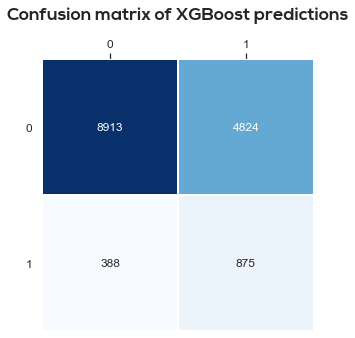

In [38]:
# Standard functions - 100 rounds
model = 'XGBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.97      0.08      0.14     13737
           1       0.09      0.97      0.16      1263

    accuracy                           0.15     15000
   macro avg       0.53      0.53      0.15     15000
weighted avg       0.90      0.15      0.15     15000



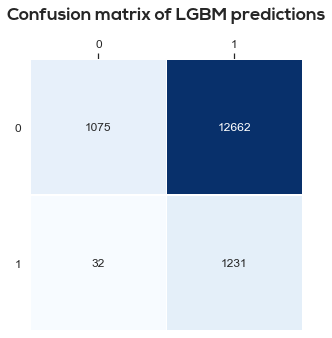

In [15]:
# Standard functions - 100 rounds
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     13737
           1       0.28      0.19      0.23      1263

    accuracy                           0.89     15000
   macro avg       0.61      0.57      0.59     15000
weighted avg       0.87      0.89      0.88     15000



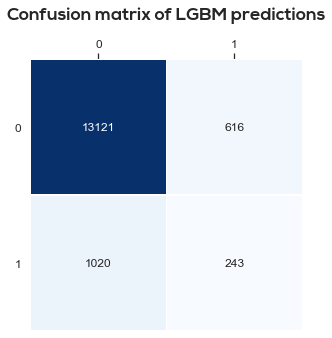

In [22]:
# Standard functions - 1000 rounds
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     13743
           1       0.17      0.67      0.27      1257

    accuracy                           0.70     15000
   macro avg       0.57      0.69      0.54     15000
weighted avg       0.89      0.70      0.77     15000



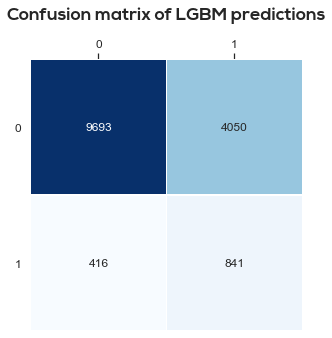

In [17]:
# Custom functions - 100 rounds
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     13743
           1       0.17      0.67      0.27      1257

    accuracy                           0.70     15000
   macro avg       0.57      0.69      0.54     15000
weighted avg       0.89      0.70      0.77     15000



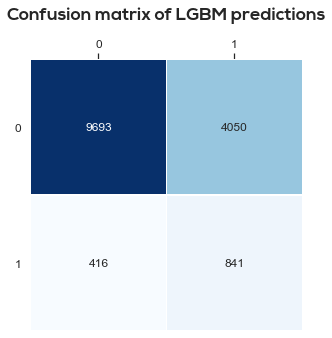

In [22]:
# Custom functions - 1000 rounds
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.63      0.76     13737
           1       0.15      0.69      0.24      1263

    accuracy                           0.64     15000
   macro avg       0.55      0.66      0.50     15000
weighted avg       0.89      0.64      0.72     15000



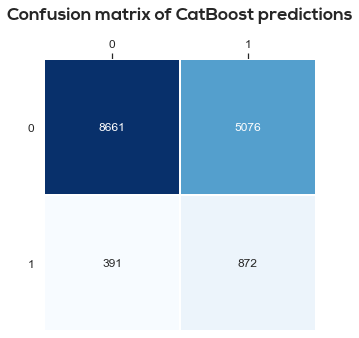

In [18]:
# Standard functions - 100 rounds
model = 'CatBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [30]:
models['LGBM'].best_score_

defaultdict(collections.OrderedDict,
            {'valid': OrderedDict([('custom logloss', 1.0920088969020632)])})

In [75]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, NaN_thresh=30, resample='RUS')

Positive weight : None

Before cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (39470, 480)

There are 0 columns with greater than 30% missing values.
After cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (39470, 480)

After encoding :
Training shape:  (50000, 569)
Testing shape:  (39470, 569)

Resampling model : RUS
After separating and resampling data:
Training shape:  (6156, 569)
Validating shape:  (15000, 569)
Testing shape:  (39470, 569)

Training until validation scores don't improve for 1000 rounds
[200]	valid's custom logloss: 1.21898
[400]	valid's custom logloss: 1.19741
[600]	valid's custom logloss: 1.21086
[800]	valid's custom logloss: 1.24255
[1000]	valid's custom logloss: 1.27754
Early stopping, best iteration is:
[7]	valid's custom logloss: 1.19551
0:	learn: 0.6841430	test: 0.6846780	best: 0.6846780 (0)	total: 68.2ms	remaining: 614ms
1:	learn: 0.6756883	test: 0.6766966	best: 0.6766966 (1)	total: 91ms	remaining: 364ms
2:	learn: 0.6682612	test: 0

In [25]:
# Standard functions - 100 rounds
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.665     0.633  0.674
LGBM               0.690     0.593  0.699
CatBoost           0.673     0.642  0.668

In [31]:
# Standard functions - 1000 rounds
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.665     0.633  0.674
LGBM               0.690     0.593  0.699
CatBoost           0.673     0.642  0.668

In [47]:
# Custom functions - 100 rounds
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.212     0.697  0.543
LGBM               0.875     0.515  0.580
CatBoost           0.673     0.642  0.668

In [76]:
# Custom functions - 1000 rounds
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.665     0.633  0.674
LGBM               0.875     0.515  0.580
CatBoost           0.682     0.641  0.669

              precision    recall  f1-score   support

           0       0.96      0.66      0.78     13737
           1       0.16      0.68      0.26      1263

    accuracy                           0.66     15000
   macro avg       0.56      0.67      0.52     15000
weighted avg       0.89      0.66      0.74     15000



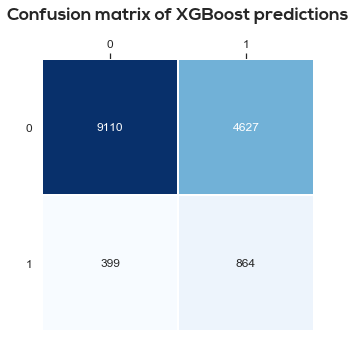

In [26]:
# Standard functions - 100 rounds
model = 'XGBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.66      0.78     13737
           1       0.16      0.68      0.26      1263

    accuracy                           0.66     15000
   macro avg       0.56      0.67      0.52     15000
weighted avg       0.89      0.66      0.74     15000



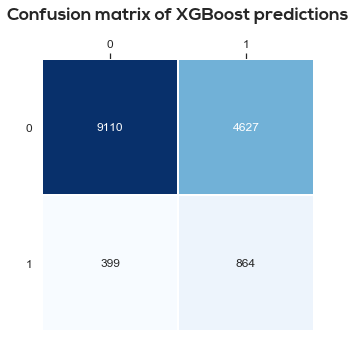

In [32]:
# Standard functions - 1000 rounds
model = 'XGBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.14      0.25     13737
           1       0.09      0.94      0.17      1263

    accuracy                           0.21     15000
   macro avg       0.53      0.54      0.21     15000
weighted avg       0.89      0.21      0.24     15000



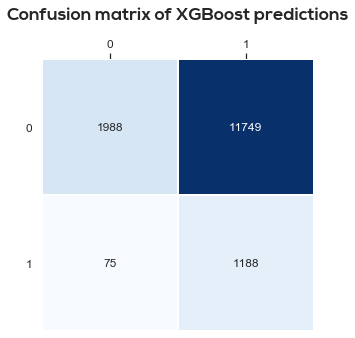

In [48]:
# Custom functions - 100 rounds
model = 'XGBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.14      0.25     13737
           1       0.09      0.94      0.17      1263

    accuracy                           0.21     15000
   macro avg       0.53      0.54      0.21     15000
weighted avg       0.89      0.21      0.24     15000



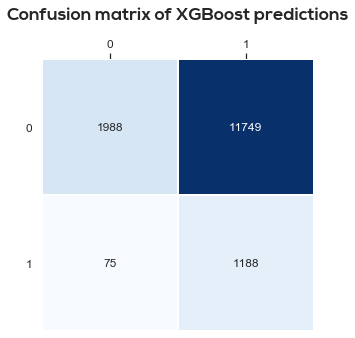

In [53]:
# Custom functions - 1000 rounds
model = 'XGBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     13737
           1       0.17      0.71      0.28      1263

    accuracy                           0.69     15000
   macro avg       0.57      0.70      0.54     15000
weighted avg       0.90      0.69      0.76     15000



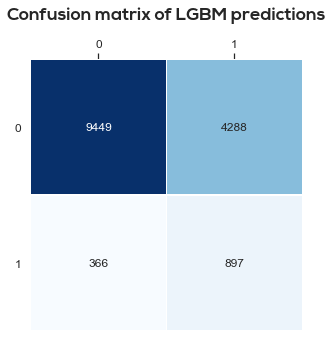

In [27]:
# Standard functions - 100 rounds
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     13737
           1       0.17      0.71      0.28      1263

    accuracy                           0.69     15000
   macro avg       0.57      0.70      0.54     15000
weighted avg       0.90      0.69      0.76     15000



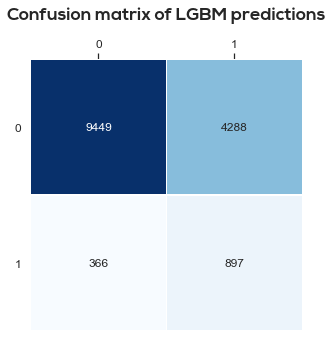

In [33]:
# Standard functions - 1000 rounds
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13737
           1       0.24      0.22      0.23      1263

    accuracy                           0.87     15000
   macro avg       0.58      0.58      0.58     15000
weighted avg       0.87      0.87      0.87     15000



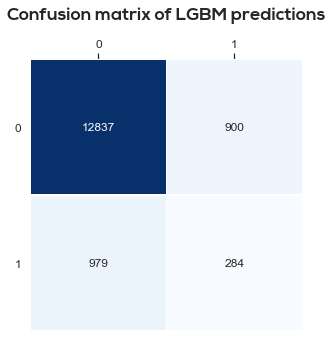

In [49]:
# Custom functions - 100 rounds
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13737
           1       0.24      0.22      0.23      1263

    accuracy                           0.87     15000
   macro avg       0.58      0.58      0.58     15000
weighted avg       0.87      0.87      0.87     15000



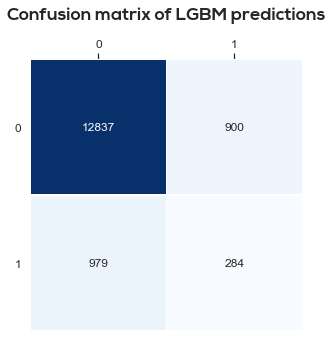

In [78]:
# Custom functions - 1000 rounds
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     13737
           1       0.16      0.66      0.25      1263

    accuracy                           0.67     15000
   macro avg       0.56      0.67      0.52     15000
weighted avg       0.89      0.67      0.75     15000



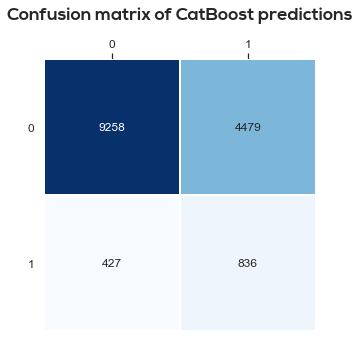

In [28]:
# Standard functions - 100 rounds
model = 'CatBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     13737
           1       0.16      0.66      0.25      1263

    accuracy                           0.67     15000
   macro avg       0.56      0.67      0.52     15000
weighted avg       0.89      0.67      0.75     15000



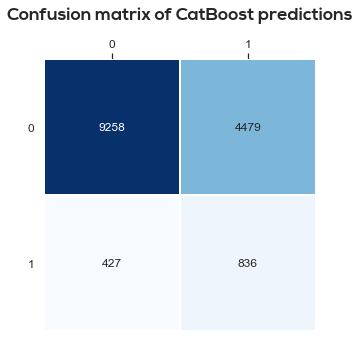

In [34]:
# Standard functions - 1000 rounds
model = 'CatBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [177]:
model = 'CatBoost'
model_ID = list(models.keys()).index(model)

print(y_valid[:10].values)
print(valid_pred[model_ID][:10])
print(valid_proba[model_ID][:10])

[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 1 1 0 0]
[0.43737729 0.43698234 0.51615598 0.34502616 0.4597431  0.3944717
 0.52802266 0.5225216  0.37112163 0.39516885]


In [35]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, NaN_thresh=20, resample='SMOTE')

Positive weight : None

Before cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (100, 480)

There are 3 columns with greater than 20% missing values.
After cleaning NaNs :
Training shape:  (50000, 477)
Testing shape:  (100, 477)

After encoding :
Training shape:  (50000, 530)
Testing shape:  (100, 530)

Resampling model : SMOTE
After separating and resampling data:
Training shape:  (64266, 530)
Validating shape:  (15000, 530)
Testing shape:  (100, 530)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid's custom logloss: 1.10151

Done in 2min 44.8s


In [36]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost           0.884     0.498  0.536
LGBM              0.894     1.818  0.543

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     13743
           1       0.19      0.12      0.14      1257

    accuracy                           0.88     15000
   macro avg       0.56      0.54      0.54     15000
weighted avg       0.86      0.88      0.87     15000



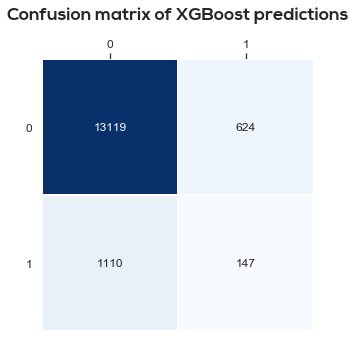

In [37]:
model = 'XGBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     13743
           1       0.24      0.12      0.16      1257

    accuracy                           0.89     15000
   macro avg       0.58      0.54      0.55     15000
weighted avg       0.87      0.89      0.88     15000



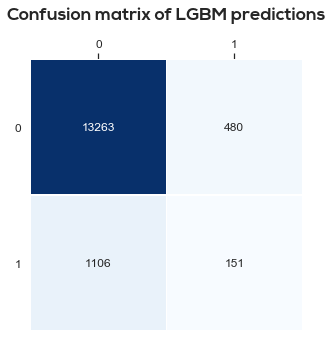

In [38]:
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

## Modèle choisi : LGBM + Random Under Sampling

### Entraînement du modèle

In [87]:
save_path = 'Figures/'

In [3]:
# Random 50000 rows
train = pd.read_csv('Fichiers/Clean/train_all_merged_mean_corrs_removed_clean_50000.csv')
test = pd.read_csv('Fichiers/Clean/test_all_merged_mean_corrs_removed_clean.csv')

In [57]:
print('Training Shape: ', train.shape)
print('Testing Shape: ', test.shape)

Training Shape:  (50000, 482)
Testing Shape:  (39470, 481)


[]

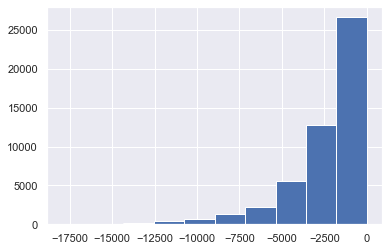

In [56]:
# Check values of DAYS_EMPLOYED
train['DAYS_EMPLOYED'].hist().plot()

In [58]:
# train_sample = train.iloc[:50000,:]
# test_sample = test.sample(n=10000, random_state=42)

train_sample = train
test_sample = test
target_names = ['0','1']

In [59]:
# Convert TARGET boolean into integers (cf. how data was built) 
train_sample['TARGET'] = train_sample['TARGET'].astype(int)
train_sample['TARGET'].unique()

array([0, 1])

In [81]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, NaN_thresh=30, resample='RUS')

Positive weight : None

Before cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (39470, 480)

There are 0 columns with greater than 30% missing values.
After cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (39470, 480)

After encoding :
Training shape:  (50000, 569)
Testing shape:  (39470, 569)

Resampling model : RUS
After separating and resampling data:
Training shape:  (6156, 569)
Validating shape:  (15000, 569)
Testing shape:  (39470, 569)

Training until validation scores don't improve for 100 rounds
[200]	valid's binary_logloss: 0.595556
Early stopping, best iteration is:
[114]	valid's binary_logloss: 0.593009
0:	learn: 0.6841430	test: 0.6846780	best: 0.6846780 (0)	total: 23.8ms	remaining: 214ms
1:	learn: 0.6756883	test: 0.6766966	best: 0.6766966 (1)	total: 53.8ms	remaining: 215ms
2:	learn: 0.6682612	test: 0.6688631	best: 0.6688631 (2)	total: 85.2ms	remaining: 199ms
3:	learn: 0.6607377	test: 0.6625089	best: 0.6625089 (3)	total: 106ms	remaining: 159ms
4:

In [82]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.665     0.633  0.674
LGBM               0.690     0.593  0.699
CatBoost           0.682     0.641  0.669

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     13737
           1       0.17      0.71      0.28      1263

    accuracy                           0.69     15000
   macro avg       0.57      0.70      0.54     15000
weighted avg       0.90      0.69      0.76     15000



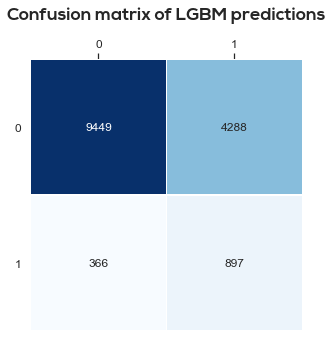

In [83]:
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

### SHAP Values

In [84]:
# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
# X,y = shap.datasets.boston()
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

df_valid = pd.DataFrame(X_valid, columns=feature_names)
model = models['LGBM']

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_valid)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
shap.force_plot(explainer.expected_value[1], shap_values[1][10], df_valid.iloc[10,:])

In [141]:
# visualize the training set predictions
# shap.force_plot(explainer.expected_value[0], shap_values[0], X)

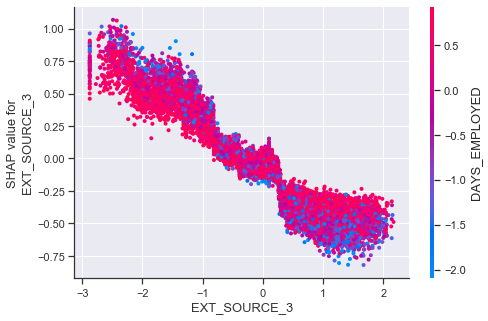

In [85]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("EXT_SOURCE_3", shap_values[1], df_valid)

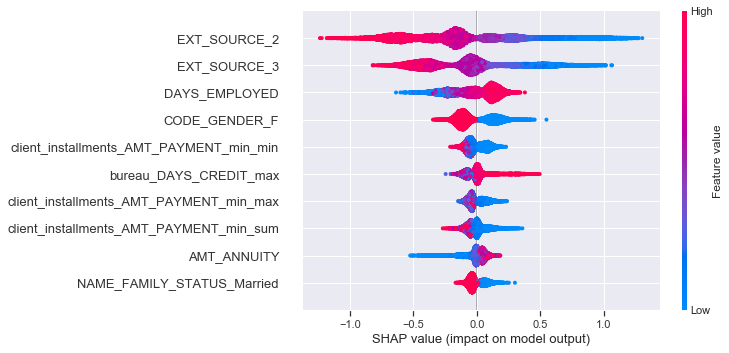

In [88]:
# summarize the effects of all the features
fig = plt.figure()
shap.summary_plot(shap_values[1], df_valid,  max_display=10, show=False)
plt.savefig(save_path+'Shap_values_LGBM.png', dpi=200, bbox_inches='tight')
plt.show()

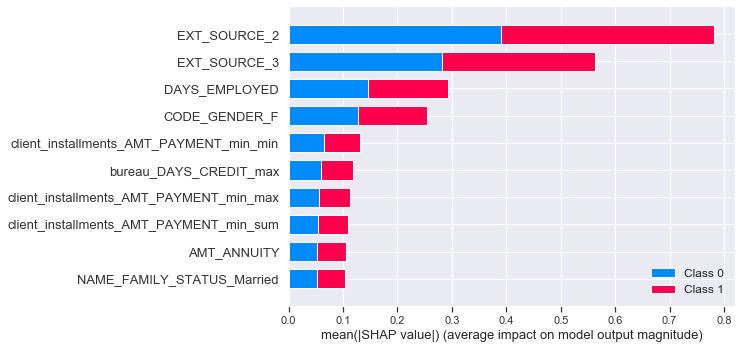

In [89]:
fig = plt.figure()
shap.summary_plot(shap_values, df_valid, plot_type="bar", max_display=10, show=False)
plt.savefig(save_path+'Shap_values_LGBM_barplot.png', dpi=200, bbox_inches='tight')
plt.show()

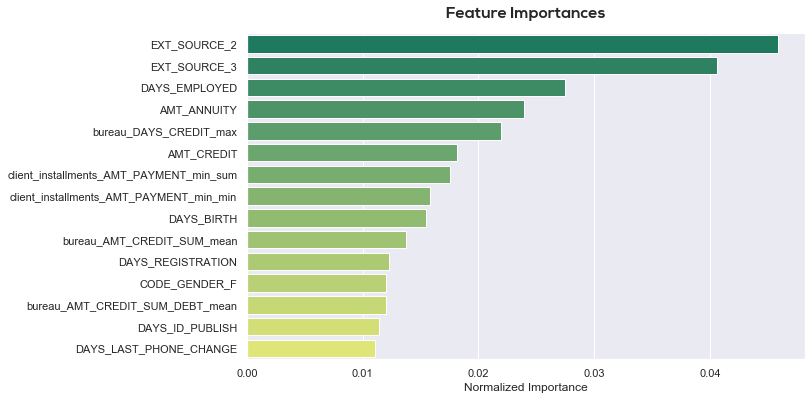

In [90]:
fi = model.feature_importances_
df = pd.DataFrame({'feature': feature_names, 'importance': fi})
df
plot_feature_importances(df)

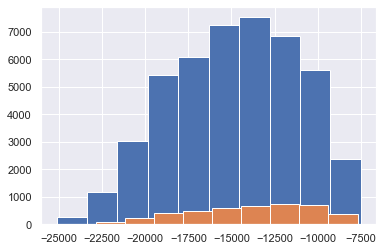

In [91]:
x = train_sample.loc[train_sample['TARGET']==0]
x2 = train_sample.loc[train_sample['TARGET']==1]
plt.hist(x['DAYS_BIRTH'])
plt.hist(x2['DAYS_BIRTH'])

plt.show()

### Clustering des SHAP Values avec KMeans

In [92]:
KMeans_path = 'Figures/KMeans'

# convert shap values array to dataframe
df_shap = pd.DataFrame(shap_values[1], columns=feature_names)

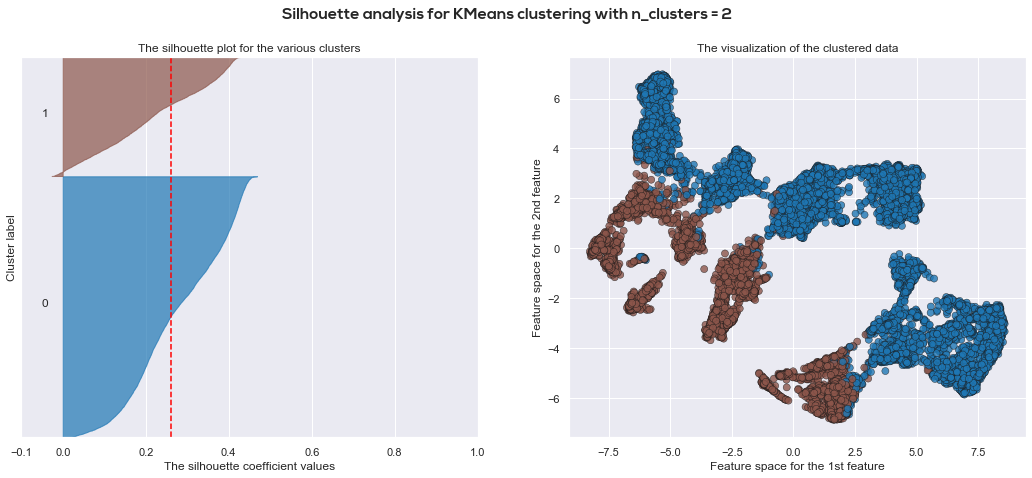

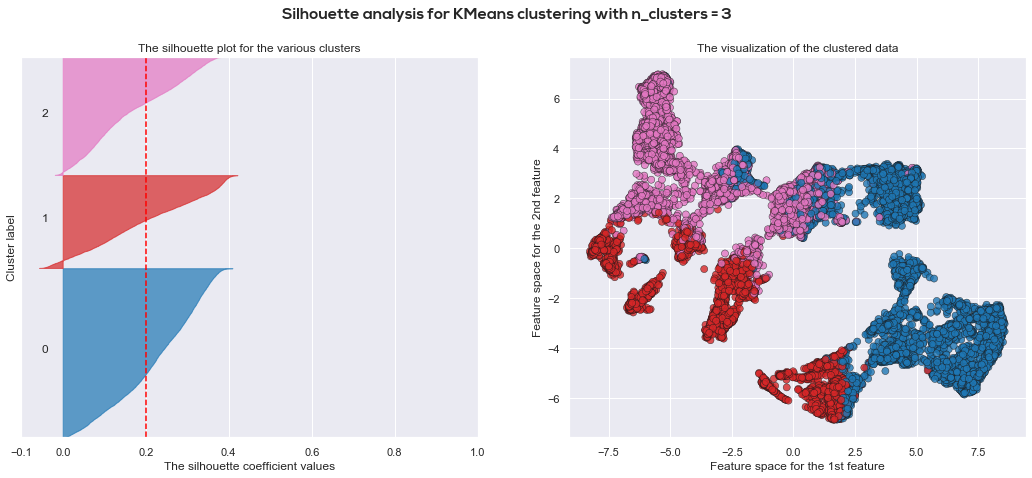

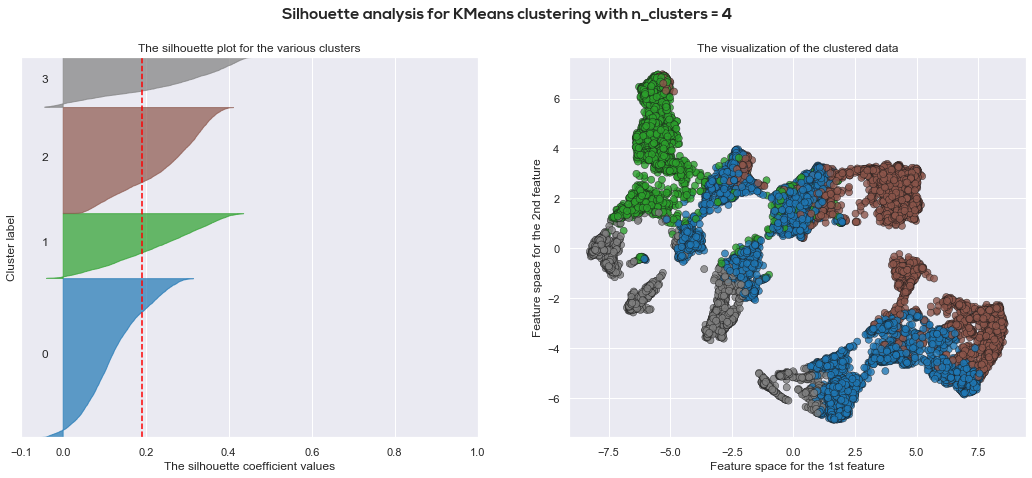

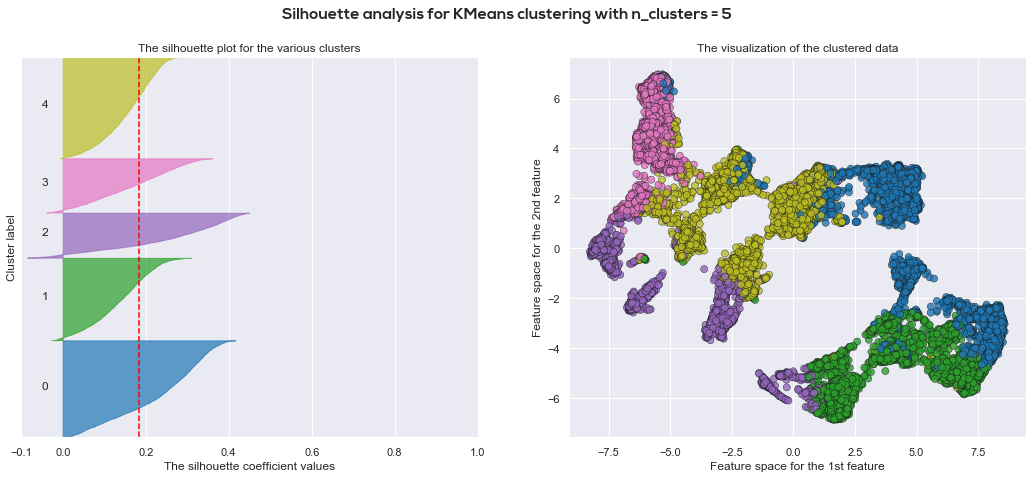

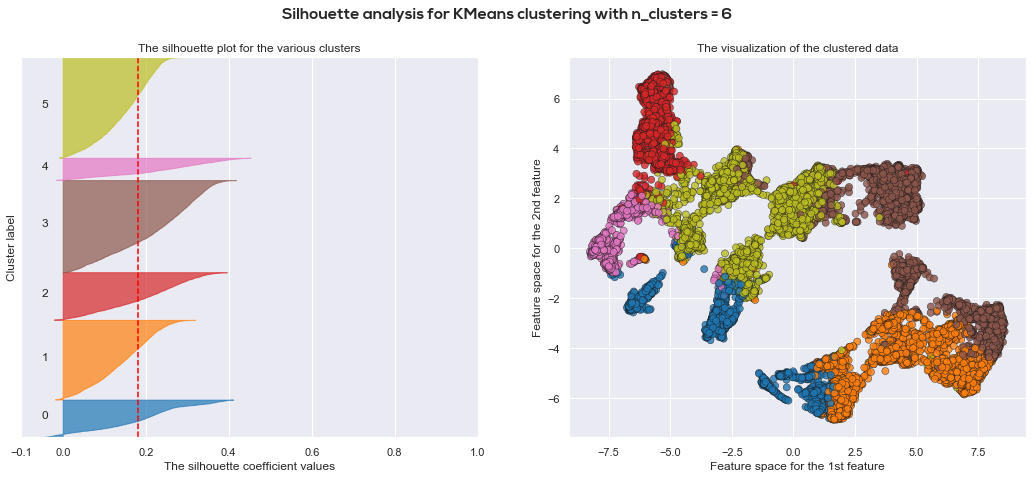

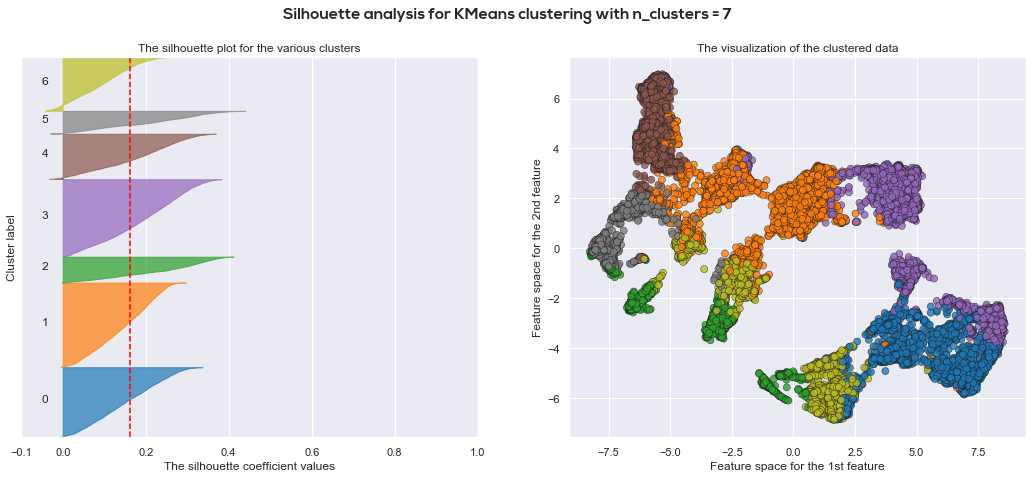

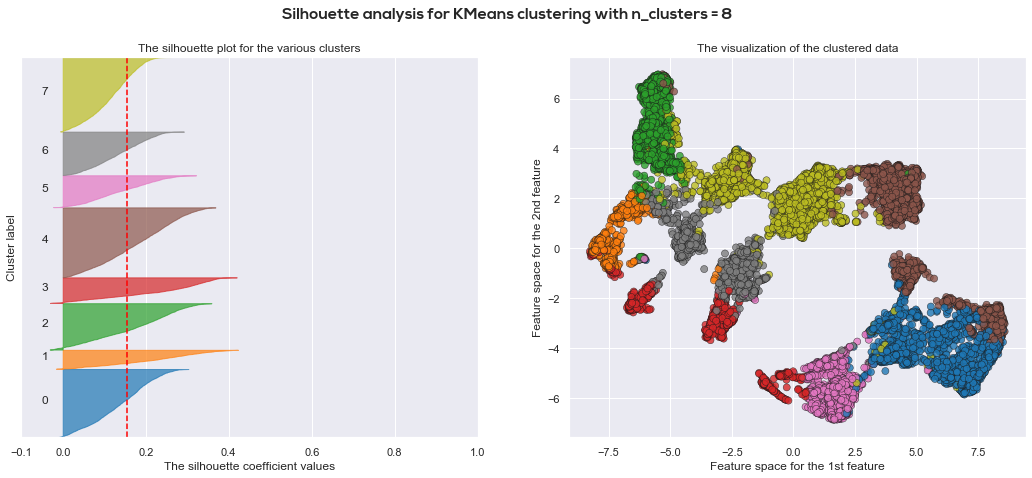

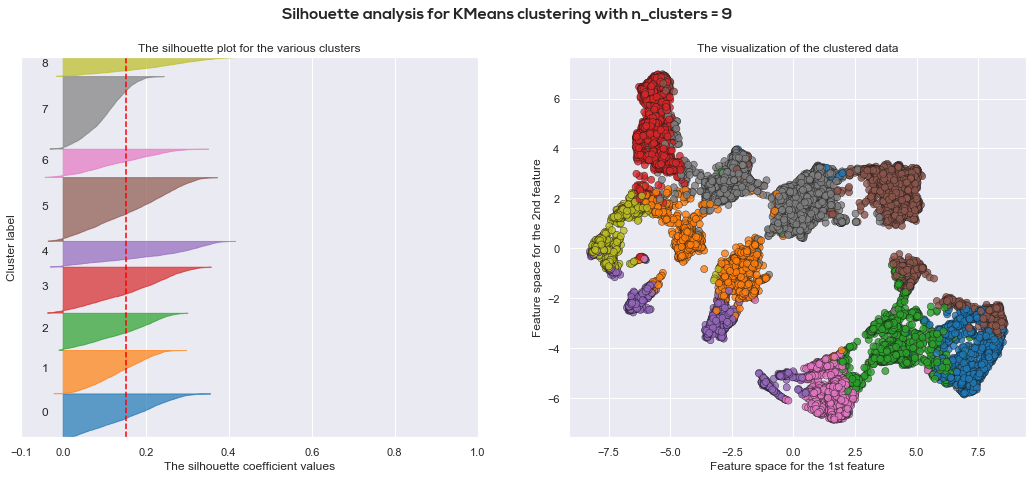

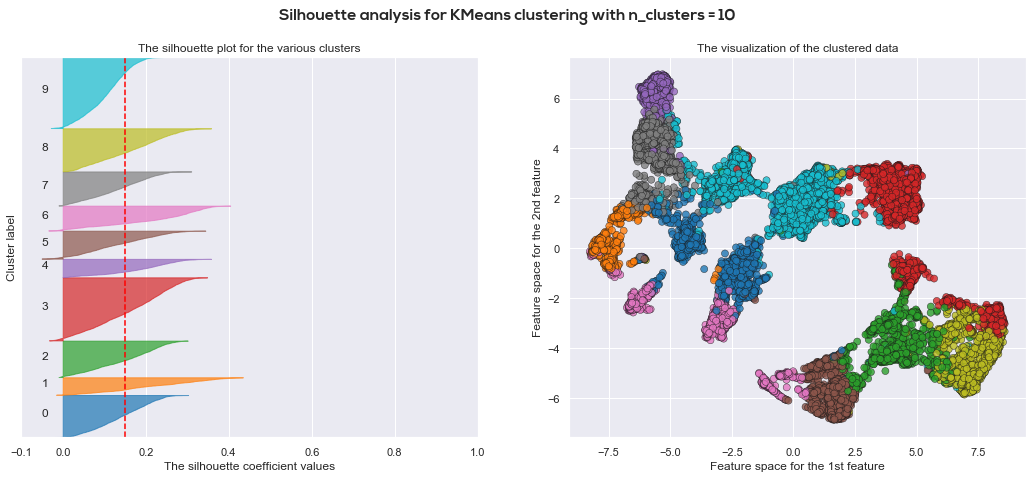


Done in 8min 41.337s


In [93]:
# On appelle notre fonction pour effectuer la boucle KMeans
range_n_clusters = range(2,11)
KMeans_scores = []

KMeans_loop(df_shap, range_n_clusters=range_n_clusters, KMeans_scores=KMeans_scores, 
            save_path=KMeans_path, proj='UMAP')

In [94]:
# convert scores into dataframe
KMeans_scores_df = pd.DataFrame(np.round(KMeans_scores,3), 
                                columns=['Silhouette','Davies-Bouldin',
                                         'Calinski-Harabasz','Inertia'], 
                                index=range_n_clusters)
KMeans_scores_df

Silhouette  Davies-Bouldin  Calinski-Harabasz   Inertia
2        0.262           1.460           5873.392  5437.131
3        0.201           1.596           5000.877  4539.143
4        0.191           1.538           4457.807  3999.565
5        0.185           1.680           4031.165  3645.856
6        0.181           1.632           3629.714  3423.097
7        0.163           1.665           3329.507  3243.995
8        0.156           1.747           3073.392  3107.322
9        0.153           1.748           2878.342  2983.542
10       0.150           1.749           2694.335  2890.490

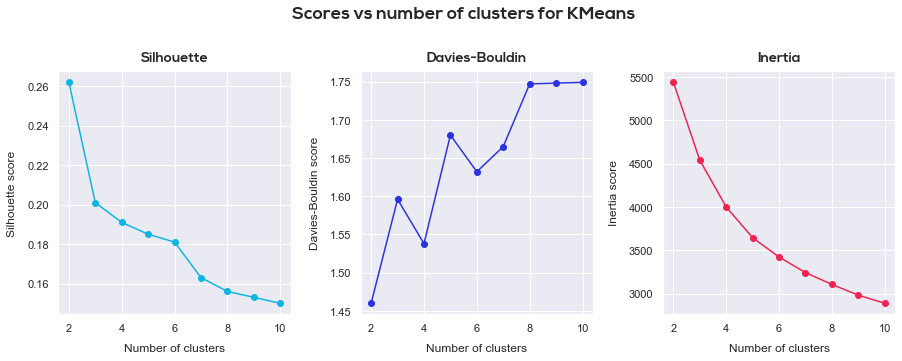

In [95]:
# Graph : scores vs number of clusters
fig = plt.figure(figsize=(15,5))

# Plot
ax = plt.subplot(131)
plt.plot(range_n_clusters, KMeans_scores_df['Silhouette'], '-o', color='#0fb5e2')

ax2 = plt.subplot(132)
plt.plot(range_n_clusters, KMeans_scores_df['Davies-Bouldin'], '-o', color='#2b33df')

ax3 = plt.subplot(133)
plt.plot(range_n_clusters, KMeans_scores_df['Inertia'], '-o', color='#f02352')

# Ajout d'éléments et sauvegarde
ax.set_xlabel('Number of clusters', fontsize=12, labelpad=10)
ax.set_ylabel('Silhouette score', fontsize=12, labelpad=10)
ax.set_title('Silhouette', fontsize=14, pad=10, **csfont)
ax2.set_xlabel('Number of clusters', fontsize=12, labelpad=10)
ax2.set_ylabel('Davies-Bouldin score', fontsize=12, labelpad=10)
ax2.set_title('Davies-Bouldin', fontsize=14, pad=10, **csfont)
ax3.set_xlabel('Number of clusters', fontsize=12, labelpad=10)
ax3.set_ylabel('Inertia score', fontsize=12, labelpad=10)
ax3.set_title('Inertia', fontsize=14, pad=10, **csfont)

plt.subplots_adjust(wspace=0.3, top=0.8)
plt.suptitle('Scores vs number of clusters for KMeans', fontsize=18, **csfont)
plt.savefig(KMeans_path+'/KMeans_Silhouette_DB_inertia.png', dpi=200, bbox_inches='tight')
plt.show()

Avec les scores et les projections 2D (UMAP) que l'on voit, on a plutôt envie de prendre K = 3 ou 6.  

Avec le nombre de données et de clients que l'on a ceci dit, on va choisir 6 clusters plutôt que 3 pour mieux les départager.

### Construction des données clients

On refait un clustering avec K = 6 sur les SHAP values comme vu dans la partie précédente.

Note : 

   - valid_data : données du jeu de validation  
   - df_valid :   données du jeu de validation après normalisation

In [96]:
# KMeans with k = 6
kmeans = KMeans(n_clusters=6, random_state=42).fit(df_shap)

# selecting cluster centroids
centroids = kmeans.cluster_centers_

In [97]:
# Create valid clients data with proba and label of clusters
valid_data = pd.DataFrame(train_sample, index=y_valid.index)

clients_data = valid_data

clients_data['Label'] = kmeans.labels_

model = 'LGBM'
model_ID = list(models.keys()).index(model)

clients_data['Proba'] = valid_proba[model_ID]

In [99]:
#Save clients_data
clients_data.to_csv('Fichiers/clients_data.csv', index=False)

In [100]:
# Valid clients data after normalization
clients = df_valid
clients.index = y_valid.index

clients['label'] = kmeans.labels_

model = 'LGBM'
model_ID = list(models.keys()).index(model)

clients['proba'] = valid_proba[model_ID]

clients['TARGET'] = y_valid
clients.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
33553     -0.654624          0.033255    0.712555     1.263493   
9427       0.651124          0.033255    0.712555     0.501231   
199        0.651124          1.035483    0.159090     1.762982   
12447     -0.654624         -0.300821    1.543206     1.479421   
39489      0.651124         -0.033560    1.726282     1.928030   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
33553                    0.402821    1.068755       0.864494   
9427                    -0.406535   -0.547623       0.796369   
199                      0.849774    0.445599       0.702434   
12447                    1.839389   -1.284204       0.579725   
39489                   -0.993900   -0.143939       0.688470   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
33553           0.998630        -0.473843    0.004472        0.006325   
9427           -1.560096         1.628935    0.004472        0.006325   
199            -0.790515        -1.735246    0.004472        0.006325   
12447           0.742512        -0.146129    0.004472        0.006325   
39489           0.525042        -1.270379    0.004472        0.006325   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
33553         1.762892          0.042228   -0.620981   -0.261095   
9427         -0.567250          0.042228   -0.620981   -0.261095   
199           1.762892          0.042228    1.610355   -0.261095   
12447        -0.567250          0.042228   -0.620981   -0.261095   
39489        -0.567250          0.042228    1.610355   -0.261095   

       REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
33553             -0.093730                 0.849792   
9427              -0.093730                 0.546840   
199               -2.057079                -0.362016   
12447             -2.057079                -0.059064   
39489             -0.093730                 1.455696   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
33553                   -0.129844                   -0.257405   
9427                    -0.129844                   -0.257405   
199                     -0.129844                   -0.257405   
12447                   -0.129844                   -0.257405   
39489                   -0.129844                   -0.257405   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
33553               -0.315329               -0.620455      1.065087   
9427                -0.315329                1.611720     -1.051362   
199                 -0.315329               -0.620455      0.597637   
12447               -0.315329               -0.620455      1.211088   
39489               -0.315329               -0.620455      0.810962   

       EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
33553      0.574852                 -0.616073                 -0.320719   
9427       0.080455                 -0.616073                 -0.320719   
199        0.100974                 -0.616073                 -0.320719   
12447      1.603273                 -0.177637                 -0.320719   
39489      2.139067                 -0.616073                 -0.320719   

       DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
33553               -1.248357        -0.008945         0.559363   
9427                 0.925003        -0.008945        -1.787747   
199                 -1.098720        -0.008945         0.559363   
12447                1.171181        -0.008945         0.559363   
39489               -0.156246        -0.008945         0.559363   

       FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
33553        -0.007746        -0.130242         -0.09783        -0.015494   
9427         -0.007746        -0.130242         -0.09783        -0.015494   
199          -0.007746        -0.130242         -0.09783        -0.015494   
12447        -0.007746        -0.130242         -0.09783    

In [101]:
bad_clients = clients[clients['TARGET']==1]

In [102]:
group = 100*bad_clients.groupby(by = ['label','TARGET']).size()/len(clients)
group = group.reset_index(level = 1, drop = True)
group = pd.DataFrame(group, columns=['Percentage'])
group

Percentage
label            
0        0.853333
1        2.200000
2        1.606667
3        1.633333
4        1.373333
5        0.753333

In [103]:
group = 100*clients.groupby(by=['label','TARGET']).size()/len(clients)
# group = group.reset_index(level=1, drop=True)
group = pd.DataFrame(group, columns=['Percentage'])
group

Percentage
label TARGET            
0     0        23.400000
      1         0.853333
1     0        24.353333
      1         2.200000
2     0        10.920000
      1         1.606667
3     0         8.233333
      1         1.633333
4     0         4.440000
      1         1.373333
5     0        20.233333
      1         0.753333

In [104]:
df_test = pd.DataFrame(test_norm, columns=feature_names)
df_test, df_shap = df_test.align(df_shap, join='inner', axis=1)
df_test.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0     -0.636165         -0.486225    0.099918    -0.607901   
1     -0.636165         -0.829381   -0.821517    -0.803204   
2     -0.636165          0.157193    0.351462     2.404834   
3      2.018531          1.229555    2.779287     1.134125   
4      0.691183         -0.057280    0.250902     0.096457   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                   -0.164806   -1.267350       0.064013          -0.173613   
1                    1.011009   -0.937121      -0.863222          -1.384626   
2                   -0.147386   -1.490963      -0.858456           0.745076   
3                    0.358627    0.209842       0.264626           0.798755   
4                   -0.776796    0.472454       0.123807           0.185274   

   DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         1.289075         0.0        0.005034        -0.581661   
1         0.772957         0.0        0.005034        -0.581661   
2        -0.423471         0.0        0.005034        -0.581661   
3        -0.872132         0.0        0.005034        -0.581661   
4        -0.906497         0.0        0.005034         1.719216   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  REGION_RATING_CLIENT  \
0          0.039343   -0.596605    2.149815             -0.059172   
1          0.039343   -0.596605   -0.465156             -0.059172   
2          0.039343   -0.596605   -0.465156             -0.059172   
3          0.039343    1.676150   -0.465156             -0.059172   
4          0.039343   -0.596605   -0.465156             -0.059172   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                 1.772760                   -0.149334   
1                -0.950276                   -0.149334   
2                 0.562522                   -0.149334   
3                -0.345157                   -0.149334   
4                -2.160515                   -0.149334   

   REG_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
0                   -0.270386               -0.313984               -0.619669   
1                   -0.270386               -0.313984               -0.619669   
2                   -0.270386               -0.313984               -0.619669   
3                   -0.270386               -0.313984               -0.619669   
4                   -0.270386               -0.313984                1.613765   

   EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0      1.504482     -1.935816                 -0.419261   
1     -1.255350     -0.350187                 -0.419261   
2      1.006450      0.682166                 -0.419261   
3     -0.047109      0.692099                 -0.419261   
4     -0.512567      0.076153                 -0.419261   

   DEF_30_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  \
0                 -0.280537               -0.737397              0.0   
1                 -0.280537                1.238656              0.0   
2                 -0.280537                0.266529              0.0   
3                 -0.280537               -0.811215              0.0   
4                 -0.280537                0.306277              0.0   

   FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
0         0.427426        -0.008719         -0.12508        -0.086629   
1         0.427426        -0.008719         -0.12508        -0.086629   
2        -2.339589        -0.008719         -0.12508        -0.086629   
3         0.427426        -0.008719         -0.12508        -0.086629   
4         0.427426        -0.008719         -0.12508        -0.086629   

   FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  \
0        -0.005034        -0.344300        -0.073834               0.0   
1        -0.005034        -0.344300        -0.073834               0.0   
2        -0.005034         2.904447        -0.073834

In [105]:
test_labels = kmeans.predict(df_test)

In [106]:
pd.set_option("display.max_rows", 100)
predictions

SK_ID_CURR  XGBoost  XGBoost (proba)  LGBM  LGBM (proba)  CatBoost  \
0          100001        0         0.368523     0      0.302039         0   
1          100005        0         0.407027     0      0.471051         0   
2          100013        0         0.372954     0      0.325465         0   
3          100028        0         0.447596     1      0.523998         0   
4          100038        0         0.408001     0      0.428223         0   
...           ...      ...              ...   ...           ...       ...   
39465      456221        0         0.402585     0      0.350848         0   
39466      456222        0         0.372954     0      0.327428         0   
39467      456223        0         0.390365     0      0.426027         0   
39468      456224        0         0.408001     1      0.527920         0   
39469      456250        0         0.484888     1      0.546088         0   

       CatBoost (proba)  
0              0.379493  
1              0.358062  
2              0.330550  
3              0.358062  
4              0.358062  
...                 ...  
39465          0.330550  
39466          0.330550  
39467          0.366134  
39468          0.358062  
39469          0.400055  

[39470 rows x 7 columns]

In [109]:
predictions['LGBM'].value_counts()

0    30472
1     8998
Name: LGBM, dtype: int64

Les prédictions de la classe positive sont du même ordre de grandeur qu'avec les données de validation, soit environ un tiers.

#### Données des clusters

Les clusters appartiennent aux données de validation à partir desquelles on a extrait les shap values pour faire le clustering.  

Un nouveau client du jeu de test a donc un label prédit et tombe dans un cluster qui contient les données de validation, et non celles du jeu test.

On construit les données de chaque cluster à partir des données normalisées (pour les shap values), par exemple :

   - cluster0_bad_clients : client appartenant au cluster 0, TARGET prédite=1 (bad) avec données normalisées
   - cluster0_bad_clients_data : pareil avec les vraies données (avant normalisation)

In [110]:
cluster0_bad_clients = clients.loc[(clients['label']==0) & (clients['TARGET']==1)]
cluster0_bad_clients.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
15079     -0.654624         -0.133783   -0.306706     0.724294   
36437      0.651124          0.701407    1.705870     0.723363   
4         -0.654624         -0.133783   -0.277483     0.387372   
8690      -0.654624          0.200293   -0.947840    -0.886789   
14617     -0.654624         -0.467859    1.667836     0.692339   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
15079                   -0.993465   -0.863301       0.715128   
36437                   -0.461381   -0.096109       0.089737   
4                       -0.738218    0.628993      -0.633398   
8690                    -0.461381    1.400012       0.710473   
14617                   -1.012882   -1.209316      -2.038200   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
15079           1.180213         0.875258    0.004472        0.006325   
36437          -0.381033        -1.480723    0.004472        0.006325   
4               0.026916         0.787560    0.004472        0.006325   
8690           -0.397289         0.438746    0.004472        0.006325   
14617           0.078446         0.056303    0.004472        0.006325   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
15079        -0.567250          0.042228   -0.620981   -0.261095   
36437        -0.567250          0.042228   -0.620981   -0.261095   
4            -0.567250          0.042228   -0.620981   -0.261095   
8690          1.762892          0.042228    1.610355   -0.261095   
14617         1.762892          0.042228    1.610355   -0.261095   

       REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
15079             -0.093730                 0.849792   
36437             -0.093730                -0.362016   
4                 -0.093730                 0.546840   
8690              -0.093730                -2.179727   
14617              1.869619                -0.059064   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
15079                   -0.129844                   -0.257405   
36437                   -0.129844                   -0.257405   
4                       -0.129844                    3.884932   
8690                    -0.129844                   -0.257405   
14617                   -0.129844                   -0.257405   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
15079               -0.315329               -0.620455      0.634163   
36437                3.171286                1.611720      0.998488   
4                   -0.315329                1.611720      0.749585   
8690                -0.315329               -0.620455      0.820898   
14617               -0.315329               -0.620455      0.980641   

       EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
15079      0.100974                 -0.616073                 -0.320719   
36437     -0.600228                 -0.616073                 -0.320719   
4          0.100974                 -0.616073                 -0.320719   
8690       0.223734                  0.699235                 -0.320719   
14617      1.320312                 -0.616073                 -0.320719   

       DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
15079                1.171181        -0.008945         0.559363   
36437               -1.895176        -0.008945         0.559363   
4                    0.713822        -0.008945        -1.787747   
8690                 0.354210        -0.008945        -1.787747   
14617               -0.769276        -0.008945        -1.787747   

       FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
15079        -0.007746        -0.130242         -0.09783        -0.015494   
36437        -0.007746        -0.130242         -0.09783        -0.015494   
4            -0.007746        -0.130242         -0.09783        -0.015494   
8690         -0.007746        -0.130242         -0.09783    

On peut regarder la distribution des probabilités sorties par le modèle pour les clients du jeu de validation dont on sait que la TARGET vaut 1. On a une majorité de probabilités supérieures à 0.5, et aussi des erreurs de prédiction en dessous de 0.5 :

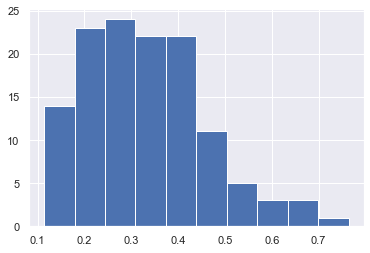

In [111]:
cluster0_bad_clients['proba'].hist().plot()
plt.show()

In [112]:
df_shap.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0      0.005066          0.005042   -0.043129     0.031461   
1     -0.009510          0.003301   -0.045042     0.018993   
2     -0.004979         -0.014672    0.050552     0.085981   
3      0.002446          0.006356    0.007359     0.035194   
4     -0.003546          0.005455   -0.076609     0.057567   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.011518    0.023228       0.215742           0.024345   
1                   -0.006636    0.026196       0.083315          -0.048508   
2                    0.008448    0.003594       0.171598          -0.045035   
3                   -0.176732   -0.058517       0.221544          -0.001690   
4                   -0.008413   -0.007497       0.252176           0.000393   

   DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         0.009883         0.0             0.0         0.000181   
1         0.065006         0.0             0.0        -0.000211   
2        -0.107387         0.0             0.0         0.000269   
3         0.001475         0.0             0.0        -0.000098   
4        -0.048221         0.0             0.0        -0.000098   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  REGION_RATING_CLIENT  \
0               0.0    0.010355    0.000422             -0.002209   
1               0.0    0.003060    0.001253             -0.008006   
2               0.0   -0.006331    0.001307             -0.015159   
3               0.0    0.001135    0.000334             -0.031111   
4               0.0   -0.019285    0.000268             -0.022269   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                 0.001377                         0.0   
1                -0.000630                         0.0   
2                 0.003192                         0.0   
3                 0.004571                         0.0   
4                -0.001342                         0.0   

   REG_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
0                   -0.000505               -0.000334               -0.001227   
1                   -0.001005               -0.000430                0.002103   
2                   -0.000878               -0.000244               -0.005793   
3                   -0.001020               -0.000335               -0.002038   
4                   -0.000411               -0.000134               -0.000949   

   EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0     -0.565590     -0.240139                  0.001666   
1      0.351407     -0.082990                  0.004951   
2     -0.352283     -0.057631                  0.004037   
3     -0.597096     -0.346860                  0.002596   
4     -0.640426     -0.330901                  0.005476   

   DEF_30_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  \
0                 -0.002644               -0.022673              0.0   
1                 -0.008537               -0.006241              0.0   
2                 -0.020274               -0.037614              0.0   
3                 -0.016910                0.036096              0.0   
4                 -0.021925                0.004654              0.0   

   FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
0         0.029607              0.0              0.0              0.0   
1        -0.090472              0.0              0.0              0.0   
2         0.027543              0.0              0.0              0.0   
3         0.024225              0.0              0.0              0.0   
4         0.017743              0.0              0.0              0.0   

   FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  \
0              0.0         0.001683              0.0               0.0   
1              0.0        -0.000498              0.0               0.0   
2              0.0        -0.001567              0.0

In [113]:
# Give index of valid data
df_shap.index = y_valid.index

In [114]:
# Save shap values
df_shap.to_csv('Fichiers/shap_values.csv', index=False)

In [115]:
# Create dataframes of each cluster with good/bad clients (TARGET = 0 / 1)
# Data needed for SHAP
cluster0_good_clients = clients.loc[(clients['label']==0) & (clients['TARGET']==0)]
cluster0_bad_clients = clients.loc[(clients['label']==0) & (clients['TARGET']==1)]
cluster1_good_clients = clients.loc[(clients['label']==1) & (clients['TARGET']==0)]
cluster1_bad_clients = clients.loc[(clients['label']==1) & (clients['TARGET']==1)]
cluster2_good_clients = clients.loc[(clients['label']==2) & (clients['TARGET']==0)]
cluster2_bad_clients = clients.loc[(clients['label']==2) & (clients['TARGET']==1)]
cluster3_good_clients = clients.loc[(clients['label']==3) & (clients['TARGET']==0)]
cluster3_bad_clients = clients.loc[(clients['label']==3) & (clients['TARGET']==1)]
cluster4_good_clients = clients.loc[(clients['label']==4) & (clients['TARGET']==0)]
cluster4_bad_clients = clients.loc[(clients['label']==4) & (clients['TARGET']==1)]
cluster5_good_clients = clients.loc[(clients['label']==5) & (clients['TARGET']==0)]
cluster5_bad_clients = clients.loc[(clients['label']==5) & (clients['TARGET']==1)]

In [116]:
# Create dataframes of each cluster with good/bad clients (TARGET = 0 / 1)
# True data before normalization
cluster0_good_clients_data = clients_data.loc[(clients['label']==0) & (clients['TARGET']==0)]
cluster0_bad_clients_data = clients_data.loc[(clients['label']==0) & (clients['TARGET']==1)]
cluster1_good_clients_data = clients_data.loc[(clients['label']==1) & (clients['TARGET']==0)]
cluster1_bad_clients_data = clients_data.loc[(clients['label']==1) & (clients['TARGET']==1)]
cluster2_good_clients_data = clients_data.loc[(clients['label']==2) & (clients['TARGET']==0)]
cluster2_bad_clients_data = clients_data.loc[(clients['label']==2) & (clients['TARGET']==1)]
cluster3_good_clients_data = clients_data.loc[(clients['label']==3) & (clients['TARGET']==0)]
cluster3_bad_clients_data = clients_data.loc[(clients['label']==3) & (clients['TARGET']==1)]
cluster4_good_clients_data = clients_data.loc[(clients['label']==4) & (clients['TARGET']==0)]
cluster4_bad_clients_data = clients_data.loc[(clients['label']==4) & (clients['TARGET']==1)]
cluster5_good_clients_data = clients_data.loc[(clients['label']==5) & (clients['TARGET']==0)]
cluster5_bad_clients_data = clients_data.loc[(clients['label']==5) & (clients['TARGET']==1)]

In [117]:
# Save all the clusters data separately because PythonAnywhere limit for one file is 100Mo
cluster0_good_clients_data.to_csv('Fichiers/Clusters/cluster0_good_clients.csv', index=False)
cluster0_bad_clients_data.to_csv('Fichiers/Clusters/cluster0_bad_clients.csv', index=False)
cluster1_good_clients_data.to_csv('Fichiers/Clusters/cluster1_good_clients.csv', index=False)
cluster1_bad_clients_data.to_csv('Fichiers/Clusters/cluster1_bad_clients.csv', index=False)
cluster2_good_clients_data.to_csv('Fichiers/Clusters/cluster2_good_clients.csv', index=False)
cluster2_bad_clients_data.to_csv('Fichiers/Clusters/cluster2_bad_clients.csv', index=False)
cluster3_good_clients_data.to_csv('Fichiers/Clusters/cluster3_good_clients.csv', index=False)
cluster3_bad_clients_data.to_csv('Fichiers/Clusters/cluster3_bad_clients.csv', index=False)
cluster4_good_clients_data.to_csv('Fichiers/Clusters/cluster4_good_clients.csv', index=False)
cluster4_bad_clients_data.to_csv('Fichiers/Clusters/cluster4_bad_clients.csv', index=False)
cluster5_good_clients_data.to_csv('Fichiers/Clusters/cluster5_good_clients.csv', index=False)
cluster5_bad_clients_data.to_csv('Fichiers/Clusters/cluster5_bad_clients.csv', index=False)

In [118]:
# Create dictionary with index of the clusters
cluster_dict = {}
cluster_dict['cluster0_good_clients'] = cluster0_good_clients.index.to_list()
cluster_dict['cluster0_bad_clients'] = cluster0_bad_clients.index.to_list()
cluster_dict['cluster1_good_clients'] = cluster1_good_clients.index.to_list()
cluster_dict['cluster1_bad_clients'] = cluster1_bad_clients.index.to_list()
cluster_dict['cluster2_good_clients'] = cluster2_good_clients.index.to_list()
cluster_dict['cluster2_bad_clients'] = cluster2_bad_clients.index.to_list()
cluster_dict['cluster3_good_clients'] = cluster3_good_clients.index.to_list()
cluster_dict['cluster3_bad_clients'] = cluster3_bad_clients.index.to_list()
cluster_dict['cluster4_good_clients'] = cluster4_good_clients.index.to_list()
cluster_dict['cluster4_bad_clients'] = cluster4_bad_clients.index.to_list()
cluster_dict['cluster5_good_clients'] = cluster5_good_clients.index.to_list()
cluster_dict['cluster5_bad_clients'] = cluster5_bad_clients.index.to_list()

# Save the dict into json file (for Flask API)
with open('clusters.json', 'w', encoding='utf-8') as f:
    json.dump(cluster_dict, f, ensure_ascii=False, indent=4)
    
# json_dict = json.dumps(cluster_dict)

In [120]:
cluster = cluster0_bad_clients.iloc[:,:-3]
cluster.shape

(128, 569)

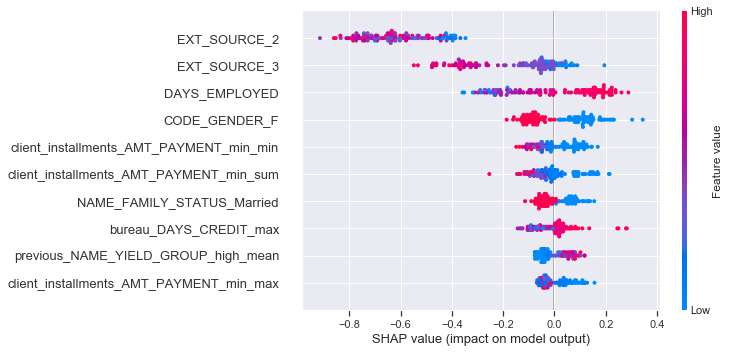

In [121]:
# summarize the effects of all the features
fig = plt.figure()
shap.summary_plot(explainer.shap_values(cluster)[1], cluster, max_display=10, show=False)
plt.savefig(save_path+'Shap_values_cluster0_bad_clients.png', dpi=200, bbox_inches='tight')
plt.show()

In [122]:
shap_cluster0_bad_clients = explainer.shap_values(cluster0_bad_clients.iloc[:,:-3])

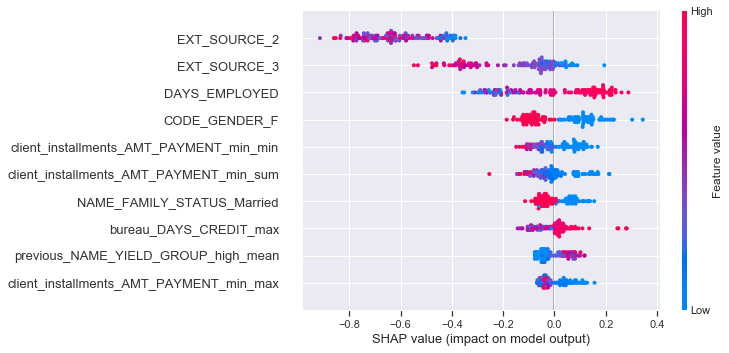

In [123]:
shap.summary_plot(shap_cluster0_bad_clients[1], cluster0_bad_clients.iloc[:,:-3], max_display=10)

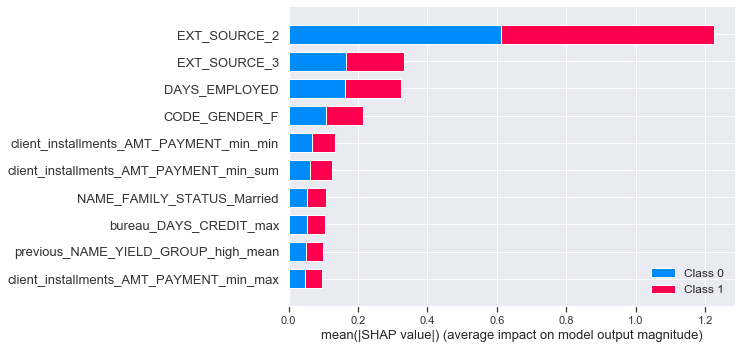

In [124]:
shap.summary_plot(shap_cluster0_bad_clients, cluster0_bad_clients.iloc[:,:-3], plot_type="bar", max_display=10)

In [125]:
# Add probas and cluster labels to the test data (before and after encoding features)
model = 'LGBM'
model_ID = list(models.keys()).index(model)

test_final = test.copy()
test_final['Proba'] = test_proba[model_ID]
test_final['Label'] = test_labels

df_test['Proba'] = test_proba[model_ID]
df_test['Label'] = test_labels

In [128]:
# Build a sample of 100 clients from test data with same weight of minority class (~10%)
test_final_neg = test_final.loc[test_final['Proba'] < 0.5]
test_final_pos = test_final.loc[test_final['Proba'] > 0.5]

test_final_neg_sample = test_final_neg.sample(90)
test_final_pos_sample = test_final_pos.sample(10)

test_final_sample = pd.concat([test_final_neg_sample,test_final_pos_sample])

In [129]:
# Selection of features we want in the dashboard
data_clients = test_final_sample[['SK_ID_CURR','CODE_GENDER','AMT_CREDIT','previous_AMT_CREDIT_mean',
                                  'AMT_ANNUITY','AMT_INCOME_TOTAL',
                                  'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH','bureau_DAYS_CREDIT_max',
                                  'EXT_SOURCE_2','EXT_SOURCE_3','FLAG_OWN_CAR','DAYS_REGISTRATION','CNT_CHILDREN',
                                  'NAME_FAMILY_STATUS','NAME_INCOME_TYPE',
                                  'Proba', 'Label'
                                  ]]

# Rename some features
data_clients = data_clients.rename({'bureau_DAYS_CREDIT_max': 'DAYS_CREDIT_max'}, axis=1)

# Transform and convert some features
data_clients = data_clients.astype({'AMT_CREDIT':'int', 'AMT_ANNUITY':'int', 'AMT_INCOME_TOTAL':'int'})
data_clients['DAYS_BIRTH'] = data_clients['DAYS_BIRTH'].abs()
data_clients['DAYS_EMPLOYED'] = data_clients['DAYS_EMPLOYED'].abs()
data_clients['DAYS_ID_PUBLISH'] = data_clients['DAYS_ID_PUBLISH'].abs()
data_clients['DAYS_CREDIT_max'] = data_clients['DAYS_CREDIT_max'].abs()
data_clients['DAYS_REGISTRATION'] = data_clients['DAYS_REGISTRATION'].abs()
data_clients = data_clients.replace({'CODE_GENDER': {'M': 'Male', 'F': 'Female'}})
data_clients = data_clients.replace({'FLAG_OWN_CAR': {'Y': 'Yes', 'N': 'No'}})

data_clients.head()

SK_ID_CURR CODE_GENDER  AMT_CREDIT  previous_AMT_CREDIT_mean  \
34800      413605      Female      601470                  292275.0   
12186      208337        Male      272520                  126546.0   
26915      342168      Female      455040                   56812.5   
1865       116292        Male     1225665                  552735.0   
4080       136730      Female      716161                  138634.5   

       AMT_ANNUITY  AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED  \
34800        30838            135000       12365           1223   
12186        16803            157500       12166            761   
26915        19260            135000       10282           1299   
1865         39667            360000       10036            105   
4080         65812            225000       13533           2227   

       DAYS_ID_PUBLISH  DAYS_CREDIT_max  EXT_SOURCE_2  EXT_SOURCE_3  \
34800             4534            187.0      0.430077      0.652896   
12186             4262           1055.0      0.347729      0.607557   
26915              514            176.0      0.680178      0.372334   
1865              2699            791.0      0.094486      0.598926   
4080              4733            171.0      0.737571      0.226347   

      FLAG_OWN_CAR  DAYS_REGISTRATION  CNT_CHILDREN NAME_FAMILY_STATUS  \
34800           No             3756.0             2     Civil marriage   
12186          Yes              832.0             1     Civil marriage   
26915           No              100.0             1            Married   
1865           Yes              375.0             1            Married   
4080            No              177.0             0            Married   

           NAME_INCOME_TYPE     Proba  Label  
34800         State servant  0.377140      2  
12186               Working  0.496205      2  
26915         State servant  0.306130      3  
1865                Working  0.379619      0  
4080   Commercial associate  0.485768      3

[]

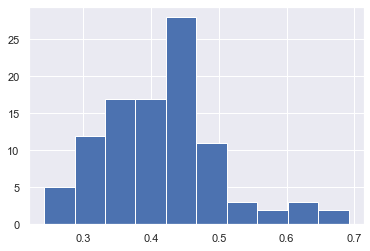

In [130]:
test_final_sample['Proba'].hist().plot()

In [131]:
# Save test clients sample for the dashboard 
data_clients.to_csv('Fichiers/tab_clients.csv', index=False)

In [132]:
# Build the same sample as above with test data after encoding (entry of model)

# Add ID column for df_test
df_test_sample = df_test.copy()
df_test_sample.insert(loc=0, column='SK_ID_CURR', value=test['SK_ID_CURR'])

df_test_sample = df_test_sample.loc[df_test_sample['SK_ID_CURR'].isin(test_final_sample['SK_ID_CURR'])]